<a href="https://colab.research.google.com/github/yucucan/DSA-210-Term-Project/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project investigates the evolving preferences of anime fans within the rapidly expanding global anime market. Once a niche interest, anime has achieved mainstream popularity, driven by its distinctive art styles and compelling narratives. The anime market, valued at USD 31.41 billion in 2023 and projected to reach USD 72.86 billion by 2032 (CAGR 9.8%), necessitates a deeper understanding of consumer trends. This research will analyze data from MyAnimeList, alongside with relevant economic and demographic data from World Bank, to identify key drivers of anime fan preferences. Specifically, this study will explore how factors such as gender. happiness score, country, age, and gdp per capita correlate with user ratings and engagement.

# Preperation

Most of the data we use for the machine learning is in google drive. This cell allows us to use the data on Google Drive

In [ ]:
import os
from os.path import join
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# to be used a prefix for file I/O
path_prefix = "/content/drive/My Drive/Colab/DSA 210/Project/Data"

Mounted at /content/drive


This cell lists the files in a specified directory and creates two lists based on these filenames.

exceptions_2015 and exceptions_2014 created here will be used in data processing. The year is last year with data on the datalists.

In [ ]:
worldbank_fname_list_csv = os.listdir(path_prefix)
worldbank_fname_list = [item[:-4] if item.endswith(".csv") else item for item in  os.listdir(path_prefix)]

exceptions_2015 = ["Renewable electricity output (% of total electricity output).csv",]
exceptions_2014 = ["Electric power consumption (kWh per capita).csv"]
len(os.listdir(path_prefix)), len(worldbank_fname_list_csv), len(worldbank_fname_list)

(55, 55, 55)

Check to see if there is any missing data

In [ ]:
n = os.listdir(path_prefix)
for item in n:
  if item not in worldbank_fname_list_csv:
    print(item)

This code block is used to set up authentication for accessing datasets from the Kaggle platform within the Google Colab environment.

In [ ]:
from google.colab import userdata
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

This code block imports various Python libraries and modules that are essential for data manipulation, analysis, visualization, and machine learning tasks.

In [ ]:
### Basic libraries
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

# Data Preprocessing
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.preprocessing import LabelEncoder


# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import re
from sklearn.tree import DecisionTreeRegressor

# Gathering Data

These code blocks are used to download datasets from Kaggle and then extract its contents.

In [ ]:
!kaggle datasets download -d mathurinache/world-happiness-report

!unzip "world-happiness-report.zip"

Dataset URL: https://www.kaggle.com/datasets/mathurinache/world-happiness-report
License(s): CC0-1.0
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 178MB/s]
Archive:  world-happiness-report.zip
  inflating: 2015.csv                
  inflating: 2016.csv                
  inflating: 2017.csv                
  inflating: 2018.csv                
  inflating: 2019.csv                
  inflating: 2020.csv                
  inflating: 2021.csv                
  inflating: 2022.csv                


In [ ]:
!kaggle datasets download -d azathoth42/myanimelist

!unzip "myanimelist.zip"

Dataset URL: https://www.kaggle.com/datasets/azathoth42/myanimelist
License(s): DbCL-1.0
100% 1.91G/1.92G [00:14<00:00, 243MB/s]
100% 1.92G/1.92G [00:14<00:00, 147MB/s]
Archive:  myanimelist.zip
  inflating: AnimeList.csv           
  inflating: UserAnimeList.csv       
  inflating: UserList.csv            
  inflating: anime_cleaned.csv       
  inflating: anime_filtered.csv      
  inflating: animelists_cleaned.csv  
  inflating: animelists_filtered.csv  
  inflating: users_cleaned.csv       
  inflating: users_filtered.csv      


# Data Preprocessing

This code block focuses on loading and cleaning dataset of World Happiness Report, into a pandas DataFrame named df.

In [ ]:
df = pd.read_csv('2020.csv')
df = df.rename(columns={"Country name": "Country"})
df.sort_values(by='Country', ascending=True, inplace=True)
df = df[df["Country"] != "Kosovo"].copy()
df = df.rename(columns={"Ladder score": "Happiness Score"})
df.reset_index(drop=True, inplace=True)
df['Country'] = df['Country'].str.lower()
df['Country'] = df['Country'].str.strip()
df.head()

Country                  Regional indicator  Happiness Score  \
0  afghanistan                          South Asia           2.5669   
1      albania          Central and Eastern Europe           4.8827   
2      algeria        Middle East and North Africa           5.0051   
3    argentina         Latin America and Caribbean           5.9747   
4      armenia  Commonwealth of Independent States           4.6768   

   Standard error of ladder score  upperwhisker  lowerwhisker  \
0                        0.031311      2.628270      2.505530   
1                        0.056116      4.992687      4.772713   
2                        0.044236      5.091802      4.918397   
3                        0.053442      6.079446      5.869954   
4                        0.058595      4.791646      4.561953   

   Logged GDP per capita  Social support  Healthy life expectancy  \
0               7.462861        0.470367                52.590000   
1               9.417931        0.671070                68.708138   
2               9.537965        0.803385                65.905174   
3               9.810955        0.900568                68.803802   
4               9.100476        0.757479                66.750656   

   Freedom to make life choices  Generosity  Perceptions of corruption  \
0                      0.396573   -0.096429                   0.933687   
1                      0.781994   -0.042309                   0.896304   
2                      0.466611   -0.121105                   0.735485   
3                      0.831132   -0.194914                   0.842010   
4                      0.712018   -0.138780                   0.773545   

   Ladder score in Dystopia  Explained by: Log GDP per capita  \
0                  1.972317                          0.300706   
1                  1.972317                          0.906653   
2                  1.972317                          0.943856   
3                  1.972317                          1.028466   
4                  1.972317                          0.808262   

   Explained by: Social support  Explained by: Healthy life expectancy  \
0                      0.356434                               0.266052   
1                      0.830484                               0.846330   
2                      1.143004                               0.745419   
3                      1.372544                               0.849774   
4                      1.034577                               0.775857   

   Explained by: Freedom to make life choices  Explained by: Generosity  \
0                                    0.000000                  0.135235   
1                                    0.461946                  0.171028   
2                                    0.083944                  0.118915   
3                                    0.520840                  0.070100   
4                                    0.378076                  0.107226   

   Explained by: Perceptions of corruption  Dystopia + residual  
0                                 0.001226             1.507236  
1                                 0.025361             1.640897  
2                                 0.129191             1.840812  
3                                 0.060415             2.072541  
4                                 0.104618             1.468162

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country                                     152 non-null    object 
 1   Regional indicator                          152 non-null    object 
 2   Happiness Score                             152 non-null    float64
 3   Standard error of ladder score              152 non-null    float64
 4   upperwhisker                                152 non-null    float64
 5   lowerwhisker                                152 non-null    float64
 6   Logged GDP per capita                       152 non-null    float64
 7   Social support                              152 non-null    float64
 8   Healthy life expectancy                     152 non-null    float64
 9   Freedom to make life choices                152 non-null    float64
 10  Generosity    

This code block iterates through a list of World Bank data filenames and merges the relevant data from each file into the main DataFrame, named df. The goal is to enrich the data with various country-level indicators from the World Bank datasets.

In [ ]:
rows_to_skip = 4
for i in range (len(worldbank_fname_list_csv)):
  fname = worldbank_fname_list_csv[i]
  df_world_bank = pd.read_csv(join(path_prefix, fname), skiprows=rows_to_skip, sep=',', on_bad_lines='skip')

  if 'Country Name' in df_world_bank.columns:
    df_world_bank['Country Name'] = df_world_bank['Country Name'].str.lower().str.strip()
  else:
    print(f"Warning: 'Country Name' column not found in {fname}")
    continue

  df_tmp = df[['Country']].copy()
  if fname in exceptions_2015:
    df_tmp = df_tmp.merge(df_world_bank[['Country Name', '2015']], left_on='Country', right_on='Country Name', how='left')
    df[worldbank_fname_list[i]] = df_tmp['2015']
  elif fname in exceptions_2014:
    df_tmp = df_tmp.merge(df_world_bank[['Country Name', '2014']], left_on='Country', right_on='Country Name', how='left')
    df[worldbank_fname_list[i]] = df_tmp['2014']
  else:
    df_tmp = df_tmp.merge(df_world_bank[['Country Name', '2020']], left_on='Country', right_on='Country Name', how='left')
    df[worldbank_fname_list[i]] = df_tmp['2020']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 75 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Country                                                                                  152 non-null    object 
 1   Regional indicator                                                                       152 non-null    object 
 2   Happiness Score                                                                          152 non-null    float64
 3   Standard error of ladder score                                                           152 non-null    float64
 4   upperwhisker                                                                             152 non-null    float64
 5   lowerwhisker                                                    

In [ ]:
df.head()

Country                  Regional indicator  Happiness Score  \
0  afghanistan                          South Asia           2.5669   
1      albania          Central and Eastern Europe           4.8827   
2      algeria        Middle East and North Africa           5.0051   
3    argentina         Latin America and Caribbean           5.9747   
4      armenia  Commonwealth of Independent States           4.6768   

   Standard error of ladder score  upperwhisker  lowerwhisker  \
0                        0.031311      2.628270      2.505530   
1                        0.056116      4.992687      4.772713   
2                        0.044236      5.091802      4.918397   
3                        0.053442      6.079446      5.869954   
4                        0.058595      4.791646      4.561953   

   Logged GDP per capita  Social support  Healthy life expectancy  \
0               7.462861        0.470367                52.590000   
1               9.417931        0.671070                68.708138   
2               9.537965        0.803385                65.905174   
3               9.810955        0.900568                68.803802   
4               9.100476        0.757479                66.750656   

   Freedom to make life choices  ...  \
0                      0.396573  ...   
1                      0.781994  ...   
2                      0.466611  ...   
3                      0.831132  ...   
4                      0.712018  ...   

   Contraceptive prevalence, any method (% of married women ages 15-49)  \
0                                                NaN                      
1                                                NaN                      
2                                                NaN                      
3                                               70.1                      
4                                                NaN                      

   Life expectancy at birth, female (years)  \
0                                    65.432   
1                                    79.676   
2                                    75.912   
3                                    79.285   
4                                    76.996   

   Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)  \
0                                                NaN                                         
1                                                NaN                                         
2                                                NaN                                         
3                                                NaN                                         
4                                                NaN                                         

   Medium and high-tech exports (% manufactured exports)  \
0                                           0.340964       
1                                           8.413831       
2                                           3.948754       
3                                          36.383624       
4                                          11.910508       

   Military expenditure (% of GDP)  Inflation, consumer prices (annual %)  \
0                         1.358857                                    NaN   
1                         1.295836                               1.620887   
2                         6.658711                               2.415131   
3                         0.734112                                    NaN   
4                         4.982544                               1.211436   

   Population, total  GDP per capita (current US$)  \
0         39068979.0                    510.787063   
1          2837849.0                   5370.778623   
2         44042091.0                   3743.541952   
3         45191965.0                   8535.599380   
4          2961500.0                   4268.680933   

   Unemployment, total (% of total labor force) (modeled ILO estimate)  \
0          

In [ ]:
df_world_bank.head(5)

Country Name Country Code  \
0                        aruba          ABW   
1  africa eastern and southern          AFE   
2                  afghanistan          AFG   
3   africa western and central          AFW   
4                       angola          AGO   

                             Indicator Name  Indicator Code      1960  \
0  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  4.820000   
1  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  6.723226   
2  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  7.282000   
3  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  6.459063   
4  Fertility rate, total (births per woman)  SP.DYN.TFRT.IN  6.708000   

       1961      1962      1963      1964      1965  ...      2015      2016  \
0  4.655000  4.471000  4.271000  4.059000  3.842000  ...  1.972000  1.953000   
1  6.742124  6.762343  6.778133  6.787821  6.799767  ...  4.678619  4.616540   
2  7.284000  7.292000  7.302000  7.304000  7.305000  ...  5.405000  5.262000   
3  6.472099  6.492395  6.506528  6.525529  6.541022  ...  5.388622  5.333061   
4  6.790000  6.872000  6.954000  7.036000  7.116000  ...  5.774000  5.686000   

       2017      2018      2019      2020      2021      2022  2023  \
0  1.839000  1.587000  1.486000  1.325000  1.180000  1.179000   NaN   
1  4.570828  4.526445  4.480001  4.412125  4.348564  4.281848   NaN   
2  5.129000  5.002000  4.870000  4.750000  4.643000  4.523000   NaN   
3  5.260538  5.191528  5.124368  5.055090  4.984759  4.903347   NaN   
4  5.600000  5.519000  5.442000  5.371000  5.304000  5.209000   NaN   

   Unnamed: 68  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 69 columns]

This code block iterates through each column in the df DataFrame to identify and handle missing values (represented as NaN). Every column that have more than 50 missing column is dropped.

In [ ]:
for col in df.columns:
    if df[col].isnull().any():
        nan_sum = df[col].isnull().sum()
        print(f"Column '{col}' has {nan_sum} NaN values.")
        if nan_sum > 50:
          df.drop(columns=[col], inplace=True)
          print(f"Column '{col}' has been dropped.")

Column 'High-technology exports (current US$)' has 35 NaN values.
Column 'Forest area (% of land area)' has 22 NaN values.
Column 'Government expenditure on education, total (% of GDP)' has 34 NaN values.
Column 'GDP per capita growth (annual %)' has 23 NaN values.
Column 'Urban population (% of total population)' has 22 NaN values.
Column 'Net migration' has 22 NaN values.
Column 'GNI per capita, PPP (current international $)' has 23 NaN values.
Column 'Exports of goods and services (% of GDP)' has 29 NaN values.
Column 'Agriculture, forestry, and fishing, value added (% of GDP)' has 23 NaN values.
Column 'Literacy rate, adult total (% of people ages 15 and above)' has 124 NaN values.
Column 'Literacy rate, adult total (% of people ages 15 and above)' has been dropped.
Column 'Access to electricity (% of population)' has 22 NaN values.
Column 'Population growth (annual %)' has 22 NaN values.
Column 'Renewable electricity output (% of total electricity output)' has 22 NaN values.
Colum

In [ ]:
df.head(5)

Country                  Regional indicator  Happiness Score  \
0  afghanistan                          South Asia           2.5669   
1      albania          Central and Eastern Europe           4.8827   
2      algeria        Middle East and North Africa           5.0051   
3    argentina         Latin America and Caribbean           5.9747   
4      armenia  Commonwealth of Independent States           4.6768   

   Standard error of ladder score  upperwhisker  lowerwhisker  \
0                        0.031311      2.628270      2.505530   
1                        0.056116      4.992687      4.772713   
2                        0.044236      5.091802      4.918397   
3                        0.053442      6.079446      5.869954   
4                        0.058595      4.791646      4.561953   

   Logged GDP per capita  Social support  Healthy life expectancy  \
0               7.462861        0.470367                52.590000   
1               9.417931        0.671070                68.708138   
2               9.537965        0.803385                65.905174   
3               9.810955        0.900568                68.803802   
4               9.100476        0.757479                66.750656   

   Freedom to make life choices  ...  \
0                      0.396573  ...   
1                      0.781994  ...   
2                      0.466611  ...   
3                      0.831132  ...   
4                      0.712018  ...   

   Refugee population by country or territory of asylum  \
0                                            72278.0      
1                                              105.0      
2                                            97651.0      
3                                             3965.0      
4                                           107910.0      

   Life expectancy at birth, male (years)  \
0                                  59.866   
1                                  74.632   
2                                  73.082   
3                                  72.546   
4                                  67.051   

   Life expectancy at birth, female (years)  \
0                                    65.432   
1                                    79.676   
2                                    75.912   
3                                    79.285   
4                                    76.996   

   Medium and high-tech exports (% manufactured exports)  \
0                                           0.340964       
1                                           8.413831       
2                                           3.948754       
3                                          36.383624       
4                                          11.910508       

   Military expenditure (% of GDP)  Inflation, consumer prices (annual %)  \
0                         1.358857                                    NaN   
1                         1.295836                               1.620887   
2                         6.658711                               2.415131   
3                         0.734112                                    NaN   
4                         4.982544                               1.211436   

   Population, total  GDP per capita (current US$)  \
0         39068979.0                    510.787063   
1          2837849.0                   5370.778623   
2         44042091.0                   3743.541952   
3         45191965.0                   8535.599380   
4          2961500.0                   4268.680933   

   Unemployment, total (% of total labor force) (modeled ILO estimate)  \
0                                             11.710                     
1                                             11.690                     
2                                             14.057                     
3                                             11.461                     
4                                             18.175                     

   Fertility rate, total (birt

In [ ]:
country_list = df['Country'].tolist()

This code block focuses on loading user data from MAL user dataset and performing initial processing steps, specifically related to dates and calculating user age.

In [ ]:
users = pd.read_csv('users_cleaned.csv')
users['join_date'] = pd.to_datetime(users['join_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['birth_date'] = pd.to_datetime(users['birth_date'])
now = datetime.datetime.now()
users['age'] = (now - users['birth_date']).dt.days / 365.25
users['age'] = users['age'].astype(int)
users.head()

username  user_id  user_watching  user_completed  user_onhold  \
0        karthiga  2255153              3              49            1   
1       Damonashu    37326             45             195           27   
2           bskai   228342             25             414            2   
3  terune_uzumaki   327311              5               5            0   
4           Bas_G  5015094             35             114            6   

   user_dropped  user_plantowatch  user_days_spent_watching  gender  \
0             0                 0                 55.091667  Female   
1            25                59                 82.574306    Male   
2             5                11                159.483333    Male   
3             0                 0                 11.394444  Female   
4            20               175                 30.458333    Male   

              location birth_date  access_rank  join_date         last_online  \
0      Chennai, India  1990-04-29          NaN 2013-03-03 2014-02-04 01:32:00   
1     Detroit,Michigan 1991-08-01          NaN 2008-02-13 2017-07-10 06:52:54   
2      Nayarit, Mexico 1990-12-14          NaN 2009-08-31 2014-05-12 16:35:00   
3    Malaysia, Kuantan 1998-08-24          NaN 2010-05-10 2012-10-18 19:06:00   
4  Nijmegen, Nederland 1999-10-24          NaN 2015-11-26 2018-05-10 20:53:37   

   stats_mean_score  stats_rewatched  stats_episodes  age  
0              7.43              0.0            3391   35  
1              6.15              6.0            4903   33  
2              8.27              1.0            9701   34  
3              9.70              6.0             697   26  
4              7.86              0.0            1847   25

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108711 entries, 0 to 108710
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   username                  108710 non-null  object        
 1   user_id                   108711 non-null  int64         
 2   user_watching             108711 non-null  int64         
 3   user_completed            108711 non-null  int64         
 4   user_onhold               108711 non-null  int64         
 5   user_dropped              108711 non-null  int64         
 6   user_plantowatch          108711 non-null  int64         
 7   user_days_spent_watching  108711 non-null  float64       
 8   gender                    108711 non-null  object        
 9   location                  108706 non-null  object        
 10  birth_date                108711 non-null  datetime64[ns]
 11  access_rank               0 non-null       float64       
 12  jo

This code block checks for and removes two columns, 'access_rank' and 'user_id', from the users DataFrame. These columns are not needed for subsequent analysis or modeling.

In [ ]:
if 'access_rank' in users.columns:
    users = users.drop(columns=['access_rank'])
    print("Column 'access_rank' dropped successfully from users.")
else:
    print("Column 'access_rank' not found in users.")

if 'user_id' in users.columns:
    users = users.drop(columns=['user_id'])
    print("Column 'user_id' dropped successfully from users.")
else:
    print("Column 'user_id' not found in users.")

Column 'access_rank' dropped successfully from users.
Column 'user_id' dropped successfully from users.


In [ ]:
us_states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho",
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana",
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "New York",
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
    "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota",
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington",
    "West Virginia", "Wisconsin", "Wyoming"
]
us_states_lower = [state.lower() for state in us_states]

Function to turn location data to country.

In [ ]:
def find_country(input):
  input = str(input)
  if input == 'nan':
    return 'Other'
  else:
    for country in country_list:
      if country in input.lower():
        return country
    for state in us_states_lower:
      if state in input.lower():
        return 'united states'
    return 'Other'

This code block applies the above function to determine the country for each user based on their location information.

In [ ]:
users['Country'] = users['location'].apply(find_country)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108711 entries, 0 to 108710
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   username                  108710 non-null  object        
 1   user_watching             108711 non-null  int64         
 2   user_completed            108711 non-null  int64         
 3   user_onhold               108711 non-null  int64         
 4   user_dropped              108711 non-null  int64         
 5   user_plantowatch          108711 non-null  int64         
 6   user_days_spent_watching  108711 non-null  float64       
 7   gender                    108711 non-null  object        
 8   location                  108706 non-null  object        
 9   birth_date                108711 non-null  datetime64[ns]
 10  join_date                 108711 non-null  datetime64[ns]
 11  last_online               108711 non-null  datetime64[ns]
 12  st

This code block drops the now unnecessary location column.

In [ ]:
if 'location' in users.columns:
    users = users.drop(columns=['location'])
    print("Column 'location' dropped successfully from users.")
else:
    print("Column 'location' not found in users.")

Column 'location' dropped successfully from users.


Country column is important to merge df to users. The rows with Other value in Country column can't be merged and thus will be dropped.

In [ ]:
other_count = users[users['Country'] == 'Other'].shape[0]
print(f"Number of 'Other' values in the 'Country' column: {other_count}")

Number of 'Other' values in the 'Country' column: 40904


This code block performs several filtering and cleaning steps on the users DataFrame to prepare it for further analysis or merging.

In [ ]:
users = users[users['Country'] != 'Other']
users = users[users['user_completed'] != 0]
users = users[users['stats_mean_score'] != 0]
users = users[users['gender'].isin(['Male', 'Female'])]
users.reset_index(drop=True, inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65828 entries, 0 to 65827
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   username                  65827 non-null  object        
 1   user_watching             65828 non-null  int64         
 2   user_completed            65828 non-null  int64         
 3   user_onhold               65828 non-null  int64         
 4   user_dropped              65828 non-null  int64         
 5   user_plantowatch          65828 non-null  int64         
 6   user_days_spent_watching  65828 non-null  float64       
 7   gender                    65828 non-null  object        
 8   birth_date                65828 non-null  datetime64[ns]
 9   join_date                 65828 non-null  datetime64[ns]
 10  last_online               65828 non-null  datetime64[ns]
 11  stats_mean_score          65828 non-null  float64       
 12  stats_rewatched   

This code block performs a merge operation between two pandas DataFrames: users and df.

In [ ]:
user_country_stats = pd.merge(users, df, on='Country', how='inner')
user_country_stats.head()

username  user_watching  user_completed  user_onhold  user_dropped  \
0        karthiga              3              49            1             0   
1       Damonashu             45             195           27            25   
2           bskai             25             414            2             5   
3  terune_uzumaki              5               5            0             0   
4        HimeAria              2              87            2             0   

   user_plantowatch  user_days_spent_watching  gender birth_date  join_date  \
0                 0                 55.091667  Female 1990-04-29 2013-03-03   
1                59                 82.574306    Male 1991-08-01 2008-02-13   
2                11                159.483333    Male 1990-12-14 2009-08-31   
3                 0                 11.394444  Female 1998-08-24 2010-05-10   
4                28                 19.963194  Female 1996-09-26 2013-09-08   

   ... Refugee population by country or territory of asylum  \
0  ...                                           195373.0     
1  ...                                           340846.0     
2  ...                                            45434.0     
3  ...                                           129902.0     
4  ...                                             2771.0     

   Life expectancy at birth, male (years)  \
0                                  68.615   
1                                  74.200   
2                                  66.334   
3                                  73.648   
4                                  72.500   

   Life expectancy at birth, female (years)  \
0                                    71.824   
1                                    79.900   
2                                    74.314   
3                                    78.472   
4                                    80.700   

   Medium and high-tech exports (% manufactured exports)  \
0                                          40.035603       
1                                          65.099982       
2                                          80.506406       
3                                          65.166040       
4                                          54.051800       

   Military expenditure (% of GDP) Inflation, consumer prices (annual %)  \
0                         2.807194                              6.623437   
1                         3.650514                              1.233584   
2                         0.717898                              3.396834   
3                         0.999654                             -1.138702   
4                         2.287485                              3.374470   

  Population, total  GDP per capita (current US$)  \
0      1.402618e+09                   1907.042516   
1      3.315269e+08                  64411.373178   
2      1.267991e+08                   8841.270750   
3      3.388956e+07                   9957.526267   
4      3.789907e+07                  15987.575365   

   Unemployment, total (% of total labor force) (modeled ILO estimate)  \
0                                              7.859                     
1                                              8.055                     
2                                              4.440                     
3                                              4.540                     
4                                              3.155                     

   Fertility rate, total (births per woman)  
0                                    2.0510  
1                                    1.6415  
2                                    1.9050  
3                                    1.8180  
4                                    1.3900  

[5 rows x 74 columns]

This code block is designed to check each column in the user_country_stats DataFrame for missing values (represented as NaN). If a column contains missing values, the code calculates the total number of missing values in that column and prints this information. If the number of missing values is bigger than 5000, the column is dropped.

In [ ]:
for col in user_country_stats.columns:
    if user_country_stats[col].isnull().any():
        nan_sum = user_country_stats[col].isnull().sum()
        print(f"Column '{col}' has {nan_sum} NaN values.")
        if nan_sum > 5000:
          user_country_stats.drop(columns=[col], inplace=True)
          print(f"Column '{col}' has been dropped.")

Column 'username' has 1 NaN values.
Column 'High-technology exports (current US$)' has 4748 NaN values.
Column 'Forest area (% of land area)' has 4350 NaN values.
Column 'Government expenditure on education, total (% of GDP)' has 5395 NaN values.
Column 'Government expenditure on education, total (% of GDP)' has been dropped.
Column 'GDP per capita growth (annual %)' has 4350 NaN values.
Column 'Urban population (% of total population)' has 4350 NaN values.
Column 'Net migration' has 4350 NaN values.
Column 'GNI per capita, PPP (current international $)' has 4350 NaN values.
Column 'Exports of goods and services (% of GDP)' has 4419 NaN values.
Column 'Agriculture, forestry, and fishing, value added (% of GDP)' has 4350 NaN values.
Column 'Access to electricity (% of population)' has 4350 NaN values.
Column 'Population growth (annual %)' has 4350 NaN values.
Column 'Renewable electricity output (% of total electricity output)' has 4350 NaN values.
Column 'Electric power consumption (kW

This code block drops the rows with NaN value in most of the columns.

In [ ]:
if 'Inflation, consumer prices (annual %)' in user_country_stats.columns:
    user_country_stats.dropna(subset=['Inflation, consumer prices (annual %)'], inplace=True)
    print("Rows with missing values in 'Inflation, consumer prices (annual %)' dropped.")
else:
    print("'Inflation, consumer prices (annual %)' column not found in the DataFrame.")

user_country_stats.info()

Rows with missing values in 'Inflation, consumer prices (annual %)' dropped.
<class 'pandas.core.frame.DataFrame'>
Index: 60925 entries, 0 to 65827
Data columns (total 70 columns):
 #   Column                                                                  Non-Null Count  Dtype         
---  ------                                                                  --------------  -----         
 0   username                                                                60924 non-null  object        
 1   user_watching                                                           60925 non-null  int64         
 2   user_completed                                                          60925 non-null  int64         
 3   user_onhold                                                             60925 non-null  int64         
 4   user_dropped                                                            60925 non-null  int64         
 5   user_plantowatch                                          

This code block is used to identify and count missing values within each column of the user_country_stats DataFrame.

In [ ]:
for col in user_country_stats.columns:
    if user_country_stats[col].isnull().any():
        nan_sum = user_country_stats[col].isnull().sum()
        print(f"Column '{col}' has {nan_sum} NaN values.")

Column 'username' has 1 NaN values.
Column 'High-technology exports (current US$)' has 398 NaN values.
Column 'Exports of goods and services (% of GDP)' has 53 NaN values.
Column 'Electric power consumption (kWh per capita)' has 31 NaN values.
Column 'Renewable internal freshwater resources per capita (cubic meters)' has 14 NaN values.
Column 'Population in the largest city (% of urban population)' has 312 NaN values.
Column 'Medium and high-tech exports (% manufactured exports)' has 41 NaN values.
Column 'Military expenditure (% of GDP)' has 252 NaN values.


This code block drops the column named username in the user_country_stats DataFrame.

In [ ]:
if 'username' in user_country_stats.columns:
    user_country_stats.dropna(subset=['username'], inplace=True)
    print("Rows with missing values in 'username' dropped.")
else:
    print("'username' column not found in the DataFrame.")

Rows with missing values in 'username' dropped.


This code block focuses on addressing any remaining missing values within the numerical columns of the user_country_stats DataFrame.

In [ ]:
numeric_columns = user_country_stats.select_dtypes(include=np.number).columns
user_country_stats[numeric_columns] = user_country_stats[numeric_columns].fillna(user_country_stats[numeric_columns].mean())

This code block is used to systematically check each column in the user_country_stats DataFrame for missing values.

In [ ]:
for col in user_country_stats.columns:
    if user_country_stats[col].isnull().any():
        nan_sum = user_country_stats[col].isnull().sum()
        print(f"Column '{col}' has {nan_sum} NaN values.")

This code block is used to remove three columns from the user_country_stats DataFrame: 'upperwhisker', 'lowerwhisker', and 'Standard error of ladder score'. These columns are considered unnecessary for the subsequent analysis or machine learning tasks.

In [ ]:
if 'upperwhisker' in user_country_stats.columns:
    user_country_stats = user_country_stats.drop(columns=['upperwhisker'])
    print("Column 'upperwhisker' dropped successfully from user_country_stats.")
else:
    print("Column 'upperwhisker' not found in user_country_stats.")

if 'lowerwhisker' in user_country_stats.columns:
    user_country_stats = user_country_stats.drop(columns=['lowerwhisker'])
    print("Column 'lowerwhisker' dropped successfully from user_country_stats.")
else:
    print("Column 'lowerwhisker' not found in user_country_stats.")

if 'Standard error of ladder score' in user_country_stats.columns:
    user_country_stats = user_country_stats.drop(columns=['Standard error of ladder score'])
    print("Column 'Standard error of ladder score' dropped successfully from user_country_stats.")
else:
    print("Column 'Standard error of ladder score' not found in user_country_stats.")

Column 'upperwhisker' dropped successfully from user_country_stats.
Column 'lowerwhisker' dropped successfully from user_country_stats.
Column 'Standard error of ladder score' dropped successfully from user_country_stats.


This code block focuses on converting categorical data in two columns of user_country_stats into a numerical format.

In [ ]:
label_encoder = LabelEncoder()
user_country_stats['Regional indicator'] = label_encoder.fit_transform(user_country_stats['Regional indicator'])
user_country_stats['Country'] = label_encoder.fit_transform(user_country_stats['Country'])

This line of code converts the categorical 'gender' column into a numerical representation, creating a new column called gender_numeric.

In [ ]:
user_country_stats['gender_numeric'] = user_country_stats['gender'].map({'Male': 0, 'Female': 1})

In [ ]:
user_country_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60924 entries, 0 to 65827
Data columns (total 68 columns):
 #   Column                                                                  Non-Null Count  Dtype         
---  ------                                                                  --------------  -----         
 0   username                                                                60924 non-null  object        
 1   user_watching                                                           60924 non-null  int64         
 2   user_completed                                                          60924 non-null  int64         
 3   user_onhold                                                             60924 non-null  int64         
 4   user_dropped                                                            60924 non-null  int64         
 5   user_plantowatch                                                        60924 non-null  int64         
 6   user_days_spent_watching   

# Conduct Exploratory Data Analysis

In [ ]:
numerical_features = ['age',
                      'stats_mean_score',
                      'Happiness Score',
                      'user_days_spent_watching',
                      'user_completed',
                      'GDP per capita (current US$)',
                      'Logged GDP per capita',
                      'Social support',
                      'Healthy life expectancy',
                      'Dystopia + residual',
                      'Freedom to make life choices',
                      'Generosity',
                      'Perceptions of corruption',
                      'user_watching',
                      'user_plantowatch']

interesting_pairs = [
    ('Happiness Score', 'Logged GDP per capita'),
    ('Happiness Score', 'Healthy life expectancy'),
    ('stats_mean_score', 'user_completed'),
    ('user_days_spent_watching', 'user_completed'),
]

This code block focuses on visualizing the distribution of the gender column in the user_country_stats DataFrame using a pie chart.

In [ ]:
categorical_feature = 'gender'
my_colors = ['#3FC1C9', '#FC5185']

gender_counts = user_country_stats[categorical_feature].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=my_colors)
plt.title(f'Distribution of {categorical_feature}')
plt.show()

This code block focuses on visualizing the relationships between specific pairs of numerical features identified as "interesting" earlier in the notebook. It uses scatter plots with regression lines to show the general trend between the features.

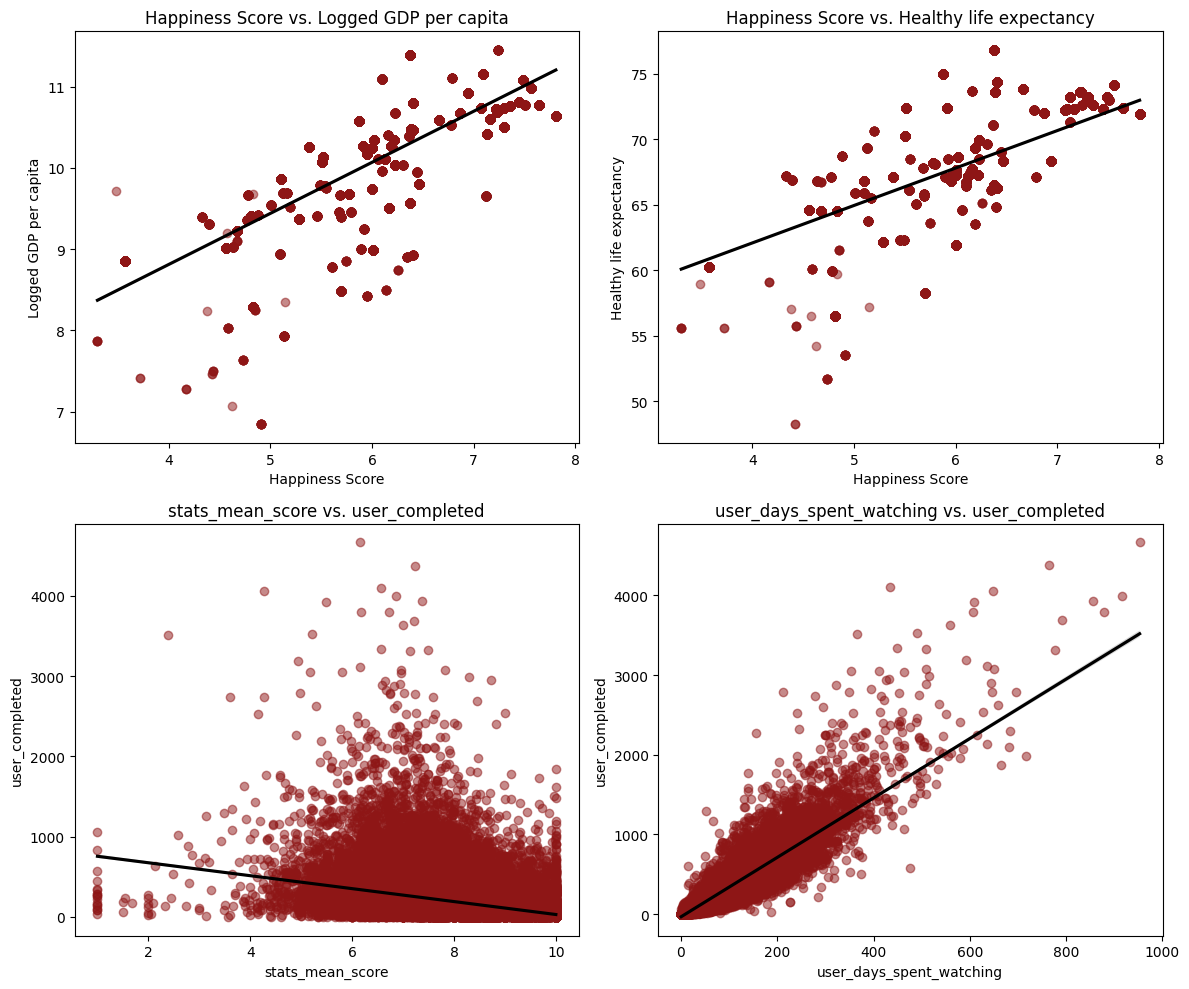

In [ ]:
num_pairs = len(interesting_pairs)
num_cols = 2
num_rows = math.ceil(num_pairs / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
axes = axes.flatten()

for i, pair in enumerate(interesting_pairs):
    feature1, feature2 = pair
    sns.regplot(x=feature1, y=feature2, data=user_country_stats, scatter_kws={'alpha': 0.5, 'color': '#8E1616'}, line_kws={'color': 'black'}, ax=axes[i])
    axes[i].set_title(f'{feature1} vs. {feature2}')

for i in range(num_pairs, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

This code block uses the Seaborn and Matplotlib libraries to create a figure with multiple plots, specifically a 2x2 grid of subplots. Each subplot visualizes the relationship between different features from the user_country_stats DataFrame, differentiated by gender.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='Happiness Score', y='stats_mean_score', hue='gender', data=user_country_stats, ax=axes[0, 0])
axes[0, 0].set_title('Mean Score vs. Happiness Score by Gender')
axes[0, 0].set_xlabel('Happiness Score')
axes[0, 0].set_ylabel('Mean Score')
axes[0, 0].legend()

sns.boxplot(x='gender', y='user_completed', data=user_country_stats, ax=axes[0, 1])
axes[0, 1].set_title('User Completed by Gender')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('User Completed')

sns.violinplot(x='gender', y='age', data=user_country_stats, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Gender')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Age')

sns.scatterplot(x='age', y='stats_mean_score', hue='gender', data=user_country_stats, ax=axes[1, 1])
axes[1, 1].set_title('Mean Score vs. Age by Gender')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Mean Score')
axes[1, 1].legend()


plt.tight_layout()
plt.show();

This code block generates a pair plot using the seaborn library. The resulting pair plot will show scatter plots for every combination of the specified numerical variables ('Happiness Score', 'stats_mean_score', 'user_completed', and 'age').

In [ ]:
sns.pairplot(user_country_stats,
             vars=['Happiness Score', 'stats_mean_score', 'user_completed', 'age'],
             hue='gender',
             palette={'Male': '#2C3E50', 'Female': '#E74C3C'})
plt.show()

This code block generates a series of violin plots, one for each numerical feature in the numerical_features list. Each plot shows the distribution of that feature for both male and female users, allowing for a visual comparison of how these distributions differ by gender.

In [ ]:
num_features = len(numerical_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.violinplot(x='gender', y=feature, data=user_country_stats, ax=axes[i], hue='gender', palette="Set2", legend=False)
    axes[i].set_title(f'{feature} Distribution by Gender')

for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

This code block focuses on visualizing the distribution of several numerical features from the user_country_stats DataFrame using histograms.

In [ ]:
num_rows = 5
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 25))

axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(user_country_stats[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

This code block calculates and visualizes the correlation matrix for the numerical features in the user_country_stats DataFrame.

In [ ]:
correlation_matrix = user_country_stats[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Hypothesis Tests

The threshold for the hypotheses is α = 0.05. If the p-value is less than or equal to α, we reject the null hypothesis and conclude that the variables are likely dependent. If the p-value is greater than α, we fail to reject the null hypothesis and conclude that the variables are likely independent.

**H1**: Users with a higher 'Mean Score' tend to have higher engagement metrics, such as a larger number of 'User Completed' anime and more 'User Days Spent Watching', suggesting satisfaction leads to deeper engagement

In [ ]:
correlation_with_completed = user_country_stats['stats_mean_score'].corr(user_country_stats['user_completed'])
correlation_with_days_spent = user_country_stats['stats_mean_score'].corr(user_country_stats['user_days_spent_watching'])

print(f"Correlation between Mean Score and User Completed: {correlation_with_completed}")
print(f"Correlation between Mean Score and User Days Spent Watching: {correlation_with_days_spent}")

Correlation between Mean Score and User Completed: -0.2983295936486229
Correlation between Mean Score and User Days Spent Watching: -0.28560726935590597


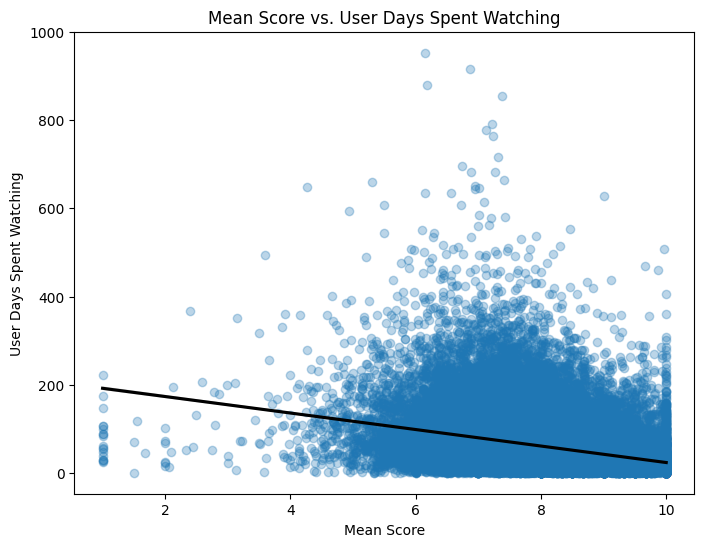

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='stats_mean_score', y='user_completed', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('Mean Score vs. User Completed')
plt.xlabel('Mean Score')
plt.ylabel('User Completed')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x='stats_mean_score', y='user_days_spent_watching', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('Mean Score vs. User Days Spent Watching')
plt.xlabel('Mean Score')
plt.ylabel('User Days Spent Watching')
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['mean_score_category'] = pd.qcut(tmp['stats_mean_score'], 3, labels=['low', 'medium', 'high'])
tmp['completed_category'] = pd.qcut(tmp['user_completed'], 3, labels=['low', 'medium', 'high'])
tmp['days_spent_category'] = pd.qcut(tmp['user_days_spent_watching'], 3, labels=['low', 'medium', 'high'])

contingency_table_completed = pd.crosstab(tmp['mean_score_category'], tmp['completed_category'])

contingency_table_days_spent = pd.crosstab(tmp['mean_score_category'], tmp['days_spent_category'])

chi2_stat_completed, p_val_completed, dof_completed, expected_completed = chi2_contingency(contingency_table_completed)

chi2_stat_days_spent, p_val_days_spent, dof_days_spent, expected_days_spent = chi2_contingency(contingency_table_days_spent)

print(f"Chi-square test for Mean Score and User Completed:")
print(f"Chi-square statistic: {chi2_stat_completed}")
print(f"P-value: {p_val_completed}")

print(f"\nChi-square test for Mean Score and User Days Spent Watching:")
print(f"Chi-square statistic: {chi2_stat_days_spent}")
print(f"P-value: {p_val_days_spent}")

Chi-square test for Mean Score and User Completed:
Chi-square statistic: 53.40157794100588
P-value: 7.022420420867169e-11

Chi-square test for Mean Score and User Days Spent Watching:
Chi-square statistic: 39.017057813558736
P-value: 6.910159230681829e-08


**Conclusion**: We reject the null hypothesis and conclude that there is a significant association

**H2**: Users from countries with higher 'GDP per capita (current US$)' tend to watch more anime ('User Completed', 'User Watched Episodes') and potentially have higher 'Mean Scores', possibly reflecting better access or more leisure time/income.

In [ ]:
correlation_with_completed = user_country_stats['GDP per capita (current US$)'].corr(user_country_stats['user_completed'])
correlation_with_days_spent = user_country_stats['GDP per capita (current US$)'].corr(user_country_stats['user_days_spent_watching'])
correlation_with_mean_score = user_country_stats['GDP per capita (current US$)'].corr(user_country_stats['stats_mean_score'])

print(f"Correlation between GDP per capita and User Completed: {correlation_with_completed}")
print(f"Correlation between GDP per capita and User Days Spent Watching: {correlation_with_days_spent}")
print(f"Correlation between GDP per capita and Mean Score: {correlation_with_mean_score}")

Correlation between GDP per capita and User Completed: -0.049227594442320624
Correlation between GDP per capita and User Days Spent Watching: -0.05220467832304506
Correlation between GDP per capita and Mean Score: -0.035823753105141014


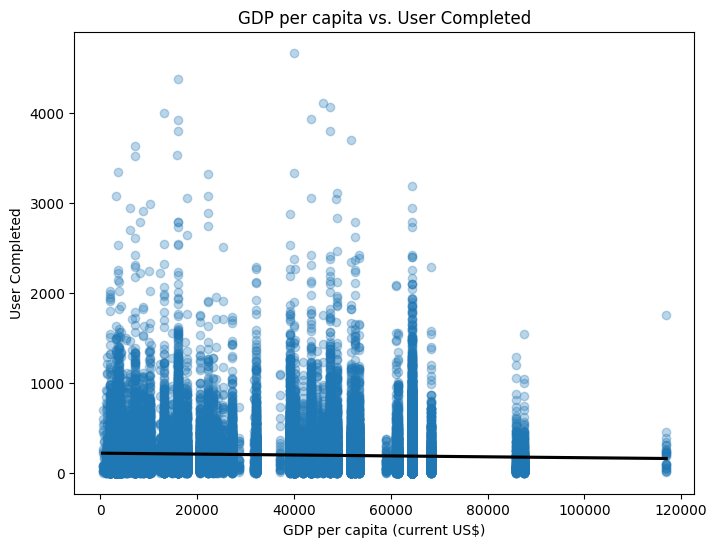

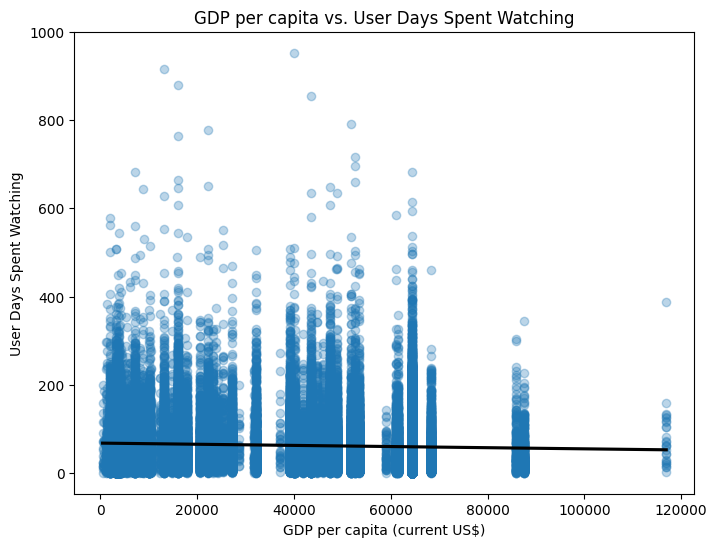

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='GDP per capita (current US$)', y='user_completed', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('GDP per capita vs. User Completed')
plt.xlabel('GDP per capita (current US$)')
plt.ylabel('User Completed')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x='GDP per capita (current US$)', y='user_days_spent_watching', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('GDP per capita vs. User Days Spent Watching')
plt.xlabel('GDP per capita (current US$)')
plt.ylabel('User Days Spent Watching')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x='GDP per capita (current US$)', y='stats_mean_score', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('GDP per capita vs. Mean Score')
plt.xlabel('GDP per capita (current US$)')
plt.ylabel('Mean Score')
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['gdp_category'] = pd.qcut(tmp['GDP per capita (current US$)'], 3, labels=['low', 'medium', 'high'])

tmp['completed_category'] = pd.qcut(tmp['user_completed'], 3, labels=['low', 'medium', 'high'])

tmp['days_spent_category'] = pd.qcut(tmp['user_days_spent_watching'], 3, labels=['low', 'medium', 'high'])

tmp['mean_score_category'] = pd.qcut(tmp['stats_mean_score'], 3, labels=['low', 'medium', 'high'])

contingency_table_completed = pd.crosstab(tmp['gdp_category'], tmp['completed_category'])

contingency_table_days_spent = pd.crosstab(tmp['gdp_category'], tmp['days_spent_category'])

contingency_table_mean_score = pd.crosstab(tmp['gdp_category'], tmp['mean_score_category'])

chi2_stat_completed, p_val_completed, dof_completed, expected_completed = chi2_contingency(contingency_table_completed)

chi2_stat_days_spent, p_val_days_spent, dof_days_spent, expected_days_spent = chi2_contingency(contingency_table_days_spent)

chi2_stat_mean_score, p_val_mean_score, dof_mean_score, expected_mean_score = chi2_contingency(contingency_table_mean_score)

print(f"Chi-square test for GDP and User Completed:")
print(f"Chi-square statistic: {chi2_stat_completed}")
print(f"P-value: {p_val_completed}")

print(f"\nChi-square test for GDP and User Days Spent Watching:")
print(f"Chi-square statistic: {chi2_stat_days_spent}")
print(f"P-value: {p_val_days_spent}")

print(f"\nChi-square test for GDP and Mean Score:")
print(f"Chi-square statistic: {chi2_stat_mean_score}")
print(f"P-value: {p_val_mean_score}")

Chi-square test for GDP and User Completed:
Chi-square statistic: 5.383837618156164
P-value: 0.25013050340042614

Chi-square test for GDP and User Days Spent Watching:
Chi-square statistic: 3.1269498625861756
P-value: 0.5368099282784534

Chi-square test for GDP and Mean Score:
Chi-square statistic: 8.533135573192155
P-value: 0.07388917746679664


 **Conclusion**: We fail to reject the null hypothesis and conclude that there is no significant association

**H3**: Higher 'Fixed broadband subscriptions', 'Mobile cellular subscriptions', or 'Secure Internet servers (per 1 million people)' correlate with higher 'User Completed' counts for users in that country.

In [ ]:
correlation_with_days_broadband = user_country_stats['Fixed broadband subscriptions (per 100 people)'].corr(user_country_stats['stats_mean_score'])
correlation_with_mobile = user_country_stats['Mobile cellular subscriptions (per 100 people)'].corr(user_country_stats['stats_mean_score'])
correlation_with_server = user_country_stats['Secure Internet servers (per 1 million people)'].corr(user_country_stats['stats_mean_score'])

print(f"Correlation between Fixed broadband subscriptions and Mean Score: {correlation_with_days_broadband}")
print(f"Correlation between Mobile cellular subscriptions and Mean Score: {correlation_with_mobile}")
print(f"Correlation between Secure Internet servers and Mean Score: {correlation_with_server}")

Correlation between Fixed broadband subscriptions and Mean Score: -0.10001294168824629
Correlation between Mobile cellular subscriptions and Mean Score: 0.009402702266438736
Correlation between Secure Internet servers and Mean Score: 0.005194191434505355


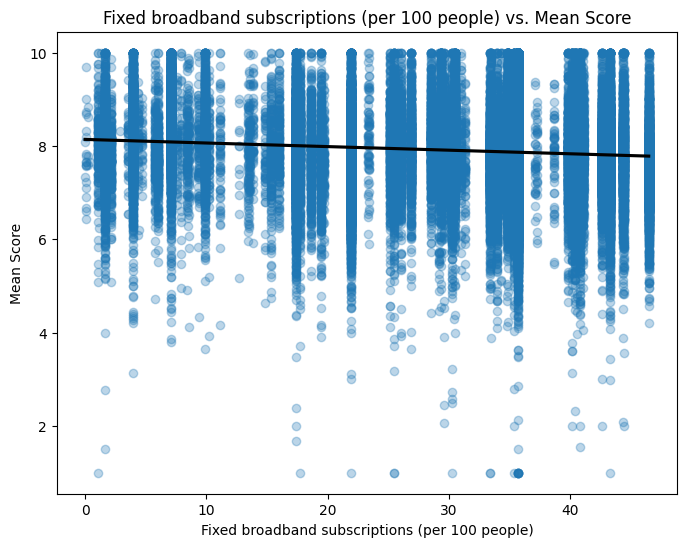

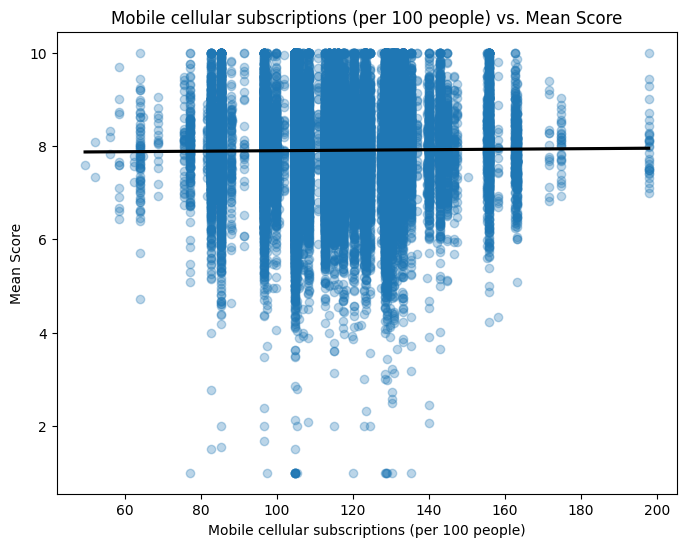

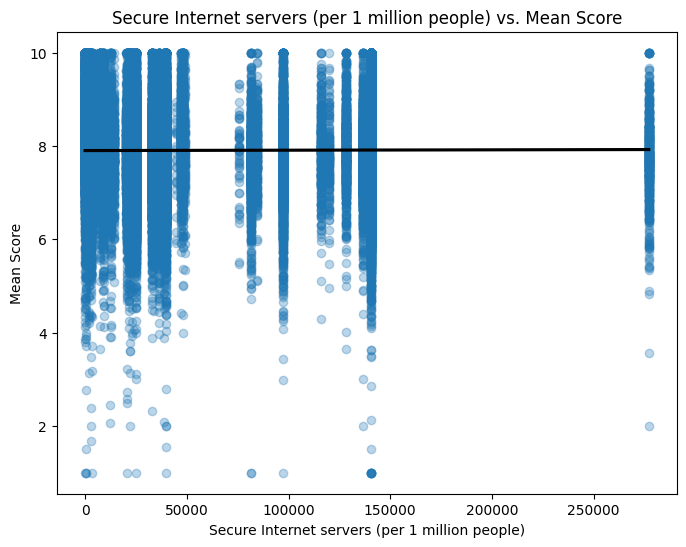

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Fixed broadband subscriptions (per 100 people)', y='stats_mean_score', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('Fixed broadband subscriptions (per 100 people) vs. Mean Score')
plt.xlabel('Fixed broadband subscriptions (per 100 people)')
plt.ylabel('Mean Score')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x='Mobile cellular subscriptions (per 100 people)', y='stats_mean_score', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('Mobile cellular subscriptions (per 100 people) vs. Mean Score')
plt.xlabel('Mobile cellular subscriptions (per 100 people)')
plt.ylabel('Mean Score')
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(x='Secure Internet servers (per 1 million people)', y='stats_mean_score', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('Secure Internet servers (per 1 million people) vs. Mean Score')
plt.xlabel('Secure Internet servers (per 1 million people)')
plt.ylabel('Mean Score')
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['broadband_category'] = pd.qcut(tmp['Fixed broadband subscriptions (per 100 people)'], 3, labels=['low', 'medium', 'high'])
tmp['mobile_category'] = pd.qcut(tmp['Mobile cellular subscriptions (per 100 people)'], 3, labels=['low', 'medium', 'high'])
tmp['server_category'] = pd.qcut(tmp['Secure Internet servers (per 1 million people)'], 3, labels=['low', 'medium', 'high'])
tmp['mean_score_category'] = pd.qcut(tmp['stats_mean_score'], 3, labels=['low', 'medium', 'high'])

contingency_table_broadband = pd.crosstab(tmp['broadband_category'], tmp['mean_score_category'])

contingency_table_mobile = pd.crosstab(tmp['mobile_category'], tmp['mean_score_category'])

contingency_table_server = pd.crosstab(tmp['server_category'], tmp['mean_score_category'])

chi2_stat_broadband, p_val_broadband, dof_broadband, expected_broadband = chi2_contingency(contingency_table_broadband)

chi2_stat_mobile, p_val_mobile, dof_mobile, expected_mobile = chi2_contingency(contingency_table_mobile)

chi2_stat_server, p_val_server, dof_server, expected_server = chi2_contingency(contingency_table_server)

print(f"Chi-square test for Fixed broadband subscriptions (per 100 people) and Mean Score:")
print(f"Chi-square statistic: {chi2_stat_broadband}")
print(f"P-value: {p_val_broadband}")

print(f"\nChi-square test for Mobile cellular subscriptions (per 100 people) and Mean Score:")
print(f"Chi-square statistic: {chi2_stat_mobile}")
print(f"P-value: {p_val_mobile}")

print(f"\nChi-square test for Secure Internet servers (per 1 million people) and Mean Score:")
print(f"Chi-square statistic: {chi2_stat_server}")
print(f"P-value: {p_val_server}")

Chi-square test for Fixed broadband subscriptions (per 100 people) and Mean Score:
Chi-square statistic: 9.162235472910053
P-value: 0.05716984705773421

Chi-square test for Mobile cellular subscriptions (per 100 people) and Mean Score:
Chi-square statistic: 3.653328246357328
P-value: 0.45495040686979304

Chi-square test for Secure Internet servers (per 1 million people) and Mean Score:
Chi-square statistic: 9.243525206249089
P-value: 0.055292535695738776


 **Conclusion**: We fail to reject the null hypothesis and conclude that there is no significant association

**H4**: Higher national happiness correlates with higher average 'User Mean Score' from users in that country.

In [ ]:
correlation = user_country_stats['Happiness Score'].corr(user_country_stats['stats_mean_score'])

print(f"Correlation between 'Happiness Score and Mean Score: {correlation}")

Correlation between 'Happiness Score and Mean Score: -0.06687589793370768


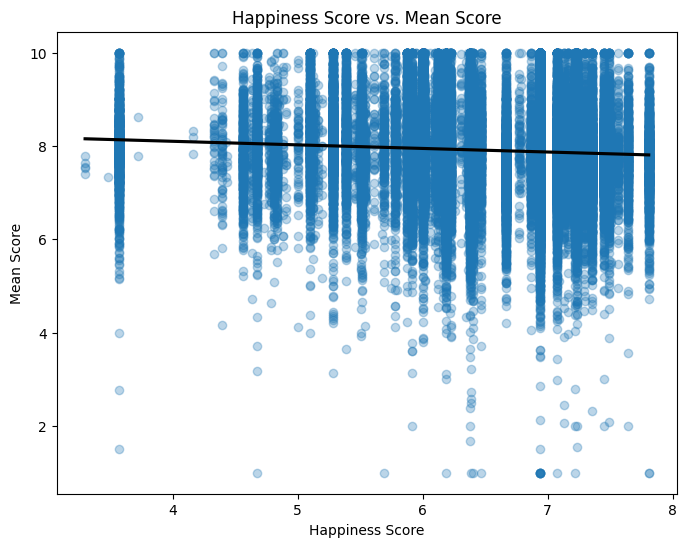

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Happiness Score', y='stats_mean_score', data=user_country_stats, scatter_kws={'alpha':0.3}, line_kws={'color': 'black'})
plt.title('Happiness Score vs. Mean Score')
plt.xlabel('Happiness Score')
plt.ylabel('Mean Score')
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['happiness_category'] = pd.qcut(tmp['Happiness Score'], 3, labels=['low', 'medium', 'high'])
tmp['mean_score_category'] = pd.qcut(tmp['stats_mean_score'], 3, labels=['low', 'medium', 'high'])

contingency_table = pd.crosstab(tmp['happiness_category'], tmp['mean_score_category'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for Happiness Score and Mean Score:")
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square test for Happiness Score and Mean Score:
Chi-square statistic: 5.702573456003083
P-value: 0.22248859870279736


**Conclusion**: We fail to reject the null hypothesis and conclude that there is no significant association

**H5**: Male and female users show differences in their anime watching habits, such as the total time spent watching anime or the average scores they give to anime.

In [ ]:
correlation_with_days_spent_watching = user_country_stats['user_days_spent_watching'].corr(user_country_stats['gender_numeric'])
correlation_with_mean_score = user_country_stats['stats_mean_score'].corr(user_country_stats['gender_numeric'])

print(f"Correlation between Gender and User Days Spent Watching: {correlation_with_days_spent_watching}")
print(f"Correlation between Gender and Mean Score: {correlation_with_mean_score}")

Correlation between Gender and User Days Spent Watching: -0.17631070389647777
Correlation between Gender and Mean Score: 0.09952580830135989


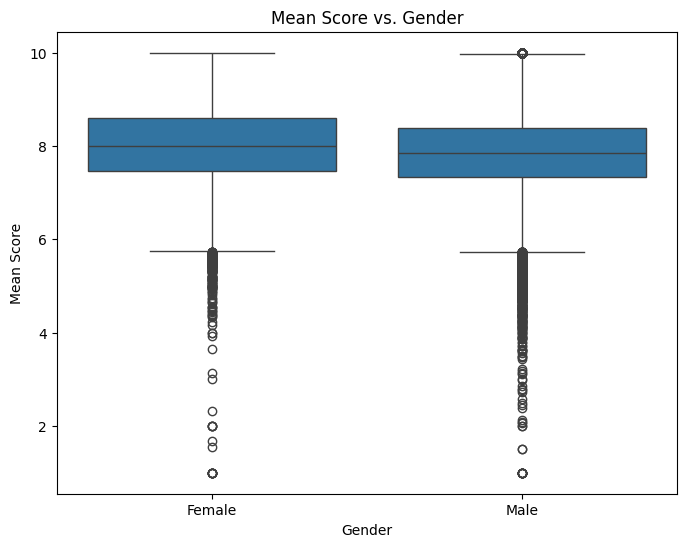

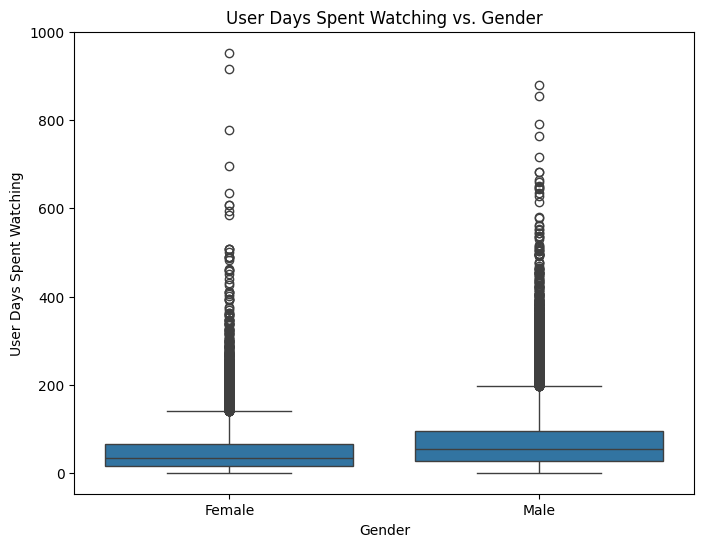

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='stats_mean_score', data=user_country_stats)
plt.title('Mean Score vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Score')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='user_days_spent_watching', data=user_country_stats)
plt.title('User Days Spent Watching vs. Gender')
plt.xlabel('Gender')
plt.ylabel('User Days Spent Watching')
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['mean_score_category'] = pd.qcut(tmp['stats_mean_score'], 3, labels=['low', 'medium', 'high'])
tmp['days_spent_watching_category'] = pd.qcut(tmp['user_days_spent_watching'], 3, labels=['low', 'medium', 'high'])

contingency_table_mean = pd.crosstab(tmp['gender'], tmp['mean_score_category'])
contingency_table_days_watching = pd.crosstab(tmp['gender'], tmp['days_spent_watching_category'])

chi2_stat_mean, p_val_mean, dof_mean, expected_mean = chi2_contingency(contingency_table_mean)

chi2_stat_days_watching, p_val_days_watching, dof_days_watching, expected_days_watching = chi2_contingency(contingency_table_days_watching)

print(f"Chi-square test for Mean Score and Gender:")
print(f"Chi-square statistic: {chi2_stat_mean}")
print(f"P-value: {p_val_mean}")

print(f"\nChi-square test for User Days Spent Watching and Gender:")
print(f"Chi-square statistic: {chi2_stat_days_watching}")
print(f"P-value: {p_val_days_watching}")

Chi-square test for Mean Score and Gender:
Chi-square statistic: 0.8739665445468503
P-value: 0.6459822371344817

Chi-square test for User Days Spent Watching and Gender:
Chi-square statistic: 12.10587008445579
P-value: 0.002350951727874106


 **Conclusion**:  We fail to reject the null hypothesis for average score and conclude that there is no significant association between gender and the average score users give to anime. However, we reject the null hypothesis for user days spent watching and conclude that there is a significant association between gender and the total time spent watching anime.

**H6**: Users from different regional indicators (e.g., Western Europe, Sub-Saharan Africa) exhibit distinct anime watching behaviors, such as mean score, watching time, or completed anime.

In [ ]:
correlation_with_days_spent_watching = user_country_stats['user_days_spent_watching'].corr(user_country_stats['Regional indicator'])
correlation_with_mean_score = user_country_stats['stats_mean_score'].corr(user_country_stats['Regional indicator'])

print(f"Correlation between Regional indicator and User Days Spent Watching: {correlation_with_days_spent_watching}")
print(f"Correlation between Regional indicator and Mean Score: {correlation_with_mean_score}")

Correlation between Regional indicator and User Days Spent Watching: 0.011590359946842354
Correlation between Regional indicator and Mean Score: -0.0521957966286115


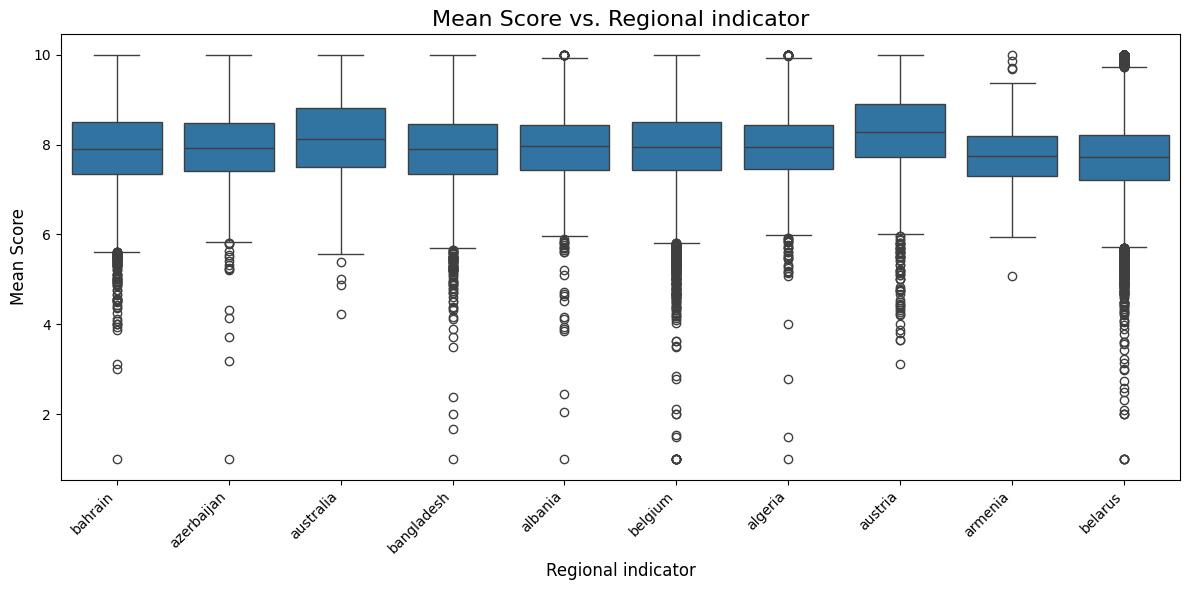

In [ ]:
original_labels = label_encoder.inverse_transform(user_country_stats['Regional indicator'].unique())

plt.figure(figsize=(12, 6))
sns.boxplot(x='Regional indicator', y='stats_mean_score', data=user_country_stats)
plt.title('Mean Score vs. Regional indicator', fontsize=16)
plt.xlabel('Regional indicator', fontsize=12)
plt.ylabel('Mean Score', fontsize=12)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Regional indicator', y='user_days_spent_watching', data=user_country_stats)
plt.title('User Days Spent Watching vs. Regional indicator', fontsize=16)
plt.xlabel('Regional indicator', fontsize=12)
plt.ylabel('User Days Spent Watching', fontsize=12)
plt.xticks(ticks=np.arange(len(original_labels)), labels=original_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['mean_score_category'] = pd.qcut(tmp['stats_mean_score'], 3, labels=['low', 'medium', 'high'])
tmp['days_spent_watching_category'] = pd.qcut(tmp['user_days_spent_watching'], 3, labels=['low', 'medium', 'high'])

contingency_table_mean = pd.crosstab(tmp['Regional indicator'], tmp['mean_score_category'])
contingency_table_days_watching = pd.crosstab(tmp['Regional indicator'], tmp['days_spent_watching_category'])

chi2_stat_mean, p_val_mean, dof_mean, expected_mean = chi2_contingency(contingency_table_mean)

chi2_stat_days_watching, p_val_days_watching, dof_days_watching, expected_days_watching = chi2_contingency(contingency_table_days_watching)

print(f"Chi-square test for Mean Score and Regional indicator:")
print(f"Chi-square statistic: {chi2_stat_mean}")
print(f"P-value: {p_val_mean}")

print(f"\nChi-square test for User Days Spent Watching and Regional indicator:")
print(f"Chi-square statistic: {chi2_stat_days_watching}")
print(f"P-value: {p_val_days_watching}")

Chi-square test for Mean Score and Regional indicator:
Chi-square statistic: 30.314558157556036
P-value: 0.03449826829611721

Chi-square test for User Days Spent Watching and Regional indicator:
Chi-square statistic: 39.6734092927294
P-value: 0.0023117573694563078


**Conclusion**: We reject the null hypothesis and conclude that there is a significant association

**H7**: There's a positive correlation between the number of anime a user is currently watching and the number they plan to watch, suggesting active viewers tend to plan future viewing.

In [ ]:
correlation = user_country_stats['user_watching'].corr(user_country_stats['user_plantowatch'])

print(f"Correlation between User Watching and User Plan to Watch: {correlation}")

Correlation between User Watching and User Plan to Watch: 0.20253436731703003


In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x='user_watching', y='user_plantowatch', data=user_country_stats, scatter_kws={'alpha':0.5, 's': 10}, line_kws={'color': 'black'})
plt.title('User Currently Watching vs. User Plan To Watch', fontsize=14)
plt.xlabel('User Currently Watching', fontsize=12)
plt.ylabel('User Plan To Watch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
tmp = user_country_stats.sample(n=500, random_state=42).copy()

tmp['user_watching_category'] = pd.qcut(tmp['user_watching'], 3, labels=['low', 'medium', 'high'])
tmp['user_plantowatch_category'] = pd.qcut(tmp['user_plantowatch'], 3, labels=['low', 'medium', 'high'])

contingency_table = pd.crosstab(tmp['user_watching_category'], tmp['user_plantowatch_category'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for User Currently Watching and User Plan To Watch:")
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square test for User Currently Watching and User Plan To Watch:
Chi-square statistic: 76.58364062372213
P-value: 9.212465740454514e-16


**Conclusion**: We reject the null hypothesis and conclude that there is a significant association

# Preperation For Machine Learning

In [ ]:
user_country_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60924 entries, 0 to 65827
Data columns (total 68 columns):
 #   Column                                                                  Non-Null Count  Dtype         
---  ------                                                                  --------------  -----         
 0   username                                                                60924 non-null  object        
 1   user_watching                                                           60924 non-null  int64         
 2   user_completed                                                          60924 non-null  int64         
 3   user_onhold                                                             60924 non-null  int64         
 4   user_dropped                                                            60924 non-null  int64         
 5   user_plantowatch                                                        60924 non-null  int64         
 6   user_days_spent_watching   

This code block removes two columns, username and gender, from the user_country_stats DataFrame.

In [ ]:
user_country_stats = user_country_stats.drop(labels="username", axis=1)
user_country_stats = user_country_stats.drop(labels="gender", axis=1)

This code block transforms the date columns in the user_country_stats DataFrame into a numerical representation.

In [ ]:
user_country_stats['join_date'] = (user_country_stats['join_date'] - pd.Timestamp('1970-01-01')).dt.days
user_country_stats['last_online'] = (user_country_stats['last_online'] - pd.Timestamp('1970-01-01')).dt.days
user_country_stats['birth_date'] = (user_country_stats['birth_date'] - pd.Timestamp('1970-01-01')).dt.days

The purpose of this function is to evaluate the performance of a machine learning model on both training and testing datasets. It calculates several common evaluation metrics and returns them in a dictionary.

In [ ]:
def show_scores(model,
                train_features,
                train_labels,
                test_features,
                test_labels):

    np.random.seed(42)
    train_preds = model.predict(X=train_features)
    test_preds = model.predict(X=test_features)

    train_preds_clipped = np.maximum(0, train_preds)
    test_preds_clipped = np.maximum(0, test_preds)

    scores = {"Training MAE": mean_absolute_error(y_true=train_labels,
                                                  y_pred=train_preds),
              "Test MAE": mean_absolute_error(y_true=test_labels,
                                               y_pred=test_preds),
              "Training RMSLE": root_mean_squared_log_error(y_true=train_labels,
                                                            y_pred=train_preds_clipped),
              "Test RMSLE": root_mean_squared_log_error(y_true=test_labels,
                                                         y_pred=test_preds_clipped),
              "Training R^2": model.score(X=train_features,
                                          y=train_labels),
              "Test R^2": model.score(X=test_features,
                                       y=test_labels)}
    return scores

# Machine Learning Model (Mean Score)



This code block prepares the sample data for training a machine learning model to predict the 'stats_mean_score'.

In [ ]:
sample = user_country_stats.sample(n=1000, random_state=42)

x_sample = sample.drop(labels="stats_mean_score", axis=1)
y_sample = sample["stats_mean_score"]

This code block splits the data into training and testing sets.

In [ ]:
x_sample_train, x_sample_test, y_sample_train, y_sample_test = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42)

This code block splits the main dataset into features and the target variable, and then further divides these into training and testing sets.

In [ ]:
X = user_country_stats.drop('stats_mean_score', axis=1)
y = user_country_stats['stats_mean_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This code block focuses on cleaning the column names of training and testing feature sets, X_train and X_test.

In [ ]:
X_train.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_train.columns]
X_test.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_test.columns]

This code block trains a baseline machine learning model, specifically a Random Forest Regressor, on a sample of the sample data and then evaluates its performance.

In [ ]:
np.random.seed(42)

base_model_sample = RandomForestRegressor(n_jobs=-1)

base_model_sample.fit(X=x_sample_train, y=y_sample_train)

base_model_sample_scores = show_scores(model=base_model_sample,
                                       train_features=x_sample_train,
                                       train_labels=y_sample_train,
                                       test_features=x_sample_test,
                                       test_labels=y_sample_test)

print(f"Model score on {len(sample)} samples:")
base_model_sample_scores

Model score on 1000 samples:


{'Training MAE': 0.24717012500000024,
 'Test MAE': 0.6344839999999998,
 'Training RMSLE': 0.038674498687953,
 'Test RMSLE': 0.10172722274203456,
 'Training R^2': 0.8779475785877052,
 'Test R^2': -0.0063945933095461704}

This code block tunes the hyperparameters of a Random Forest Regressor model using a technique called Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1),
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"], }

sample_rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=3,
                              verbose=3)

sample_rs_model.fit(X=x_sample_train,
                    y=y_sample_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.145 total time=   0.6s
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.110 total time=   0.6s
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.158 total time=   0.6s
[CV 1/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.124 total time=   0.5s
[CV 2/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.130 total time=   0.5s
[CV 3/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.156 total time=   0.5s
[CV 1/3] END max_depth=10, max_features=0.5, min_samples_leaf=9, min_samples_split=5, n_estimators=140;, score=0.128 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=3)

In [ ]:
sample_rs_model.best_params_

{'n_estimators': np.int64(150),
 'min_samples_split': np.int64(7),
 'min_samples_leaf': np.int64(1),
 'max_features': 'sqrt',
 'max_depth': 10}

In [ ]:
sample_rs_model_scores = show_scores(model=sample_rs_model,
                                     train_features=x_sample_train,
                                     train_labels=y_sample_train,
                                     test_features=x_sample_test,
                                     test_labels=y_sample_test)
sample_rs_model_scores

{'Training MAE': 0.4282388818111595,
 'Test MAE': 0.5979108009171518,
 'Training RMSLE': 0.06718667252319614,
 'Test RMSLE': 0.08965091362916926,
 'Training R^2': 0.626504320648437,
 'Test R^2': 0.175379145651261}

This code block performs a Grid Search to find the best hyperparameters for a RandomForestRegressor model using the sample training data.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(50, 150, 50),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 8, 2),
           "min_samples_leaf": np.arange(2, 6, 2),
           "max_features": [0.5, "sqrt"],
           "oob_score": [True, False]
}

sample_gs_model = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                              param_grid=rf_grid,
                              cv=3,
                              verbose=3,
                              n_jobs=-1)

sample_gs_model.fit(X=x_sample_train,
                    y=y_sample_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [0.5, 'sqrt'],
                         'min_samples_leaf': array([2, 4]),
                         'min_samples_split': array([2, 4, 6]),
                         'n_estimators': array([ 50, 100]),
                         'oob_score': [True, False]},
             verbose=3)

In [ ]:
sample_gs_model.best_params_

{'max_depth': 10,
 'max_features': 0.5,
 'min_samples_leaf': np.int64(4),
 'min_samples_split': np.int64(2),
 'n_estimators': np.int64(100),
 'oob_score': False}

In [ ]:
sample_gs_model_scores = show_scores(model=sample_rs_model,
                                     train_features=x_sample_train,
                                     train_labels=y_sample_train,
                                     test_features=x_sample_test,
                                     test_labels=y_sample_test)
sample_gs_model_scores

{'Training MAE': 0.4282388818111595,
 'Test MAE': 0.5979108009171518,
 'Training RMSLE': 0.06718667252319614,
 'Test RMSLE': 0.08965091362916926,
 'Training R^2': 0.626504320648437,
 'Test R^2': 0.175379145651261}

This code block sets up and runs a HalvingRandomSearchCV for a RandomForestRegressor model. The goal is to find the best combination of hyperparameters for the model efficiently.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1),
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"],
           "oob_score": [True, False]}

sample_hrs_model = HalvingRandomSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                                        param_distributions=rf_grid,
                                        cv=3,
                                        verbose=3,
                                        n_jobs=-1)

sample_hrs_model.fit(X=x_sample_train,
                    y=y_sample_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 6
max_resources_: 800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 133
n_resources: 6
Fitting 3 folds for each of 133 candidates, totalling 399 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 1
n_candidates: 45
n_resources: 18
Fitting 3 folds for each of 45 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 2
n_candidates: 15
n_resources: 54
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 3
n_candidates: 5
n_resources: 162
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 4
n_candidates: 2
n_resources: 486
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

HalvingRandomSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
                      n_jobs=-1,
                      param_distributions={'max_depth': [None, 10, 20],
                                           'max_features': [0.5, 1.0, 'sqrt'],
                                           'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                           'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                           'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190]),
                                           'oob_score': [True, False]},
                      verbose=3)

In [ ]:
sample_hrs_model.best_params_

{'oob_score': False,
 'n_estimators': np.int64(90),
 'min_samples_split': np.int64(9),
 'min_samples_leaf': np.int64(7),
 'max_features': 'sqrt',
 'max_depth': 10}

In [ ]:
sample_hrs_model_scores = show_scores(model=sample_hrs_model,
                                     train_features=x_sample_train,
                                      train_labels=y_sample_train,
                                      test_features=x_sample_test,
                                      test_labels=y_sample_test)
sample_hrs_model_scores

{'Training MAE': 0.5158075035008145,
 'Test MAE': 0.5807193498483294,
 'Training RMSLE': 0.08305704803787987,
 'Test RMSLE': 0.08779701839845318,
 'Training R^2': 0.431613061749733,
 'Test R^2': 0.21029860671427314}

This code block trains a baseline machine learning model, specifically a Random Forest Regressor, on the full training dataset and then evaluates its performance.

In [ ]:
base_model = RandomForestRegressor(n_jobs=-1)

base_model.fit(X=X_train, y=y_train)

base_model_scores = show_scores(model=base_model,
                                train_features=X_train,
                                train_labels=y_train,
                                test_features=X_test,
                                test_labels=y_test)
base_model_scores

{'Training MAE': 0.2205965304991896,
 'Test MAE': 0.5887088469429627,
 'Training RMSLE': 0.038302907056537425,
 'Test RMSLE': 0.09367731487555116,
 'Training R^2': 0.8946714395636954,
 'Test R^2': 0.2453869189700515}

This code block focuses on tuning the hyperparameters of a RandomForestRegressor model using Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1),
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"], }

rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=3,
                              verbose=3)

rs_model.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.246 total time=  14.1s
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.247 total time=  14.6s
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.235 total time=  18.3s
[CV 1/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.257 total time=  40.0s
[CV 2/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.261 total time=  37.9s
[CV 3/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.251 total time=  37.1s
[CV 1/3] END max_depth=10, max_features=0.5, min_samples_leaf=9, min_samples_split=5, n_estimators=140;, score=0.262 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=3)

In [ ]:
rs_model.best_params_

{'n_estimators': np.int64(140),
 'min_samples_split': np.int64(5),
 'min_samples_leaf': np.int64(9),
 'max_features': 0.5,
 'max_depth': 10}

In [ ]:
rs_model_scores = show_scores(model=rs_model,
                              train_features=X_train,
                              train_labels=y_train,
                              test_features=X_test,
                              test_labels=y_test)
rs_model_scores

{'Training MAE': 0.5473572853514472,
 'Test MAE': 0.5809276716238158,
 'Training RMSLE': 0.08870563578612232,
 'Test RMSLE': 0.09300200957031936,
 'Training R^2': 0.35659503446317753,
 'Test R^2': 0.25901433056358125}

This code block takes the best hyperparameters found during a previous randomized search on a sample of the data (sample_rs_model.best_params_) and uses them to train a new RandomForestRegressor model on the full training dataset (X_train, y_train).

In [ ]:
np.random.seed(42)

rf_best_model_rs = RandomForestRegressor(**sample_rs_model.best_params_, n_jobs=-1)

rf_best_model_rs.fit(X=X_train,
                  y=y_train)

rf_best_model_rs_scores = show_scores(model=rf_best_model_rs,
                                   train_features=X_train,
                                   train_labels=y_train,
                                   test_features=X_test,
                                   test_labels=y_test)

rf_best_model_rs_scores

{'Training MAE': 0.5624191487918332,
 'Test MAE': 0.5876372043698553,
 'Training RMSLE': 0.09061482159477974,
 'Test RMSLE': 0.09415714889156918,
 'Training R^2': 0.32594390438005383,
 'Test R^2': 0.24094986223080406}

This code block trains a machine learning model, specifically a Random Forest Regressor, using the optimal hyperparameters found during a previous Grid Search performed on a sample of the data. It then evaluates the performance of this trained model.

In [ ]:
np.random.seed(42)

rf_best_model_gs = RandomForestRegressor(**sample_gs_model.best_params_, n_jobs=-1)

rf_best_model_gs.fit(X=X_train,
                  y=y_train)

rf_best_model_gs_scores = show_scores(model=rf_best_model_gs,
                                   train_features=X_train,
                                   train_labels=y_train,
                                   test_features=X_test,
                                   test_labels=y_test)

rf_best_model_gs_scores

{'Training MAE': 0.5435080531798863,
 'Test MAE': 0.5814392662242237,
 'Training RMSLE': 0.08762451259715064,
 'Test RMSLE': 0.09304934505106814,
 'Training R^2': 0.3703261958364007,
 'Test R^2': 0.2581559797832569}

This code block trains a machine learning model, specifically a Random Forest Regressor, using the optimal hyperparameters found during a previous Halving Randomized Search performed on a sample of the data. It then evaluates the performance of this trained model.

In [ ]:
np.random.seed(42)

rf_best_model_hrs = RandomForestRegressor(**sample_hrs_model.best_params_, n_jobs=-1)

rf_best_model_hrs.fit(X=X_train,
                  y=y_train)

rf_best_model_hrs_scores = show_scores(model=rf_best_model_hrs,
                                   train_features=X_train,
                                   train_labels=y_train,
                                   test_features=X_test,
                                   test_labels=y_test)

rf_best_model_hrs_scores

{'Training MAE': 0.565585096031433,
 'Test MAE': 0.5875540100160795,
 'Training RMSLE': 0.09170307199110485,
 'Test RMSLE': 0.09412788456318996,
 'Training R^2': 0.3115352189683698,
 'Test R^2': 0.24132504820335732}

This code block is setting up and running a HalvingRandomSearchCV for a RandomForestRegressor model. The goal is to efficiently find the best combination of hyperparameters for the model by exploring a range of possible values.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(50, 300, 25),
           "max_depth": [10, 20, 30, None],
           "min_samples_split": np.arange(5, 20, 2),
           "min_samples_leaf": np.arange(3, 15, 2),
           "max_features": [0.5, 0.7, 1.0, "sqrt"],
           "bootstrap": [True, False],
           "oob_score": [True, False]}

halving_rs_model = HalvingRandomSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                                        param_distributions=rf_grid,
                                        cv=5,
                                        verbose=3,
                                        n_jobs=-1)

halving_rs_model.fit(X_train, y_train)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 10
max_resources_: 48739
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4873
n_resources: 10
Fitting 5 folds for each of 4873 candidates, totalling 24365 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6055 fits failed out of a total of 24365.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6055 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 448, in fit
    raise ValueError("Out 

----------
iter: 1
n_candidates: 1625
n_resources: 30
Fitting 5 folds for each of 1625 candidates, totalling 8125 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2005 fits failed out of a total of 8125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2005 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 448, in fit
    raise ValueError("Out o

----------
iter: 2
n_candidates: 542
n_resources: 90
Fitting 5 folds for each of 542 candidates, totalling 2710 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ...  0.03550518  0.10197764
 -0.00157941]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [            nan             nan -4.44089210e-17 ...  6.26935135e-01
  7.06175891e-01  7.62732700e-01]
  warnings.warn(


----------
iter: 3
n_candidates: 181
n_resources: 270
Fitting 5 folds for each of 181 candidates, totalling 905 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.19993382 0.18858467 0.18282247]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [            nan             nan -4.44089210e-17 ...  6.83255267e-01
  7.25171879e-01  7.30219253e-01]
  warnings.warn(


----------
iter: 4
n_candidates: 61
n_resources: 810
Fitting 5 folds for each of 61 candidates, totalling 305 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.17594261 0.17946484 0.18733503]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [            nan             nan -4.44089210e-17 ...  6.83298780e-01
  5.94897933e-01  5.76805513e-01]
  warnings.warn(


----------
iter: 5
n_candidates: 21
n_resources: 2430
Fitting 5 folds for each of 21 candidates, totalling 105 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.21349511 0.21380906 0.21609788]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [            nan             nan -4.44089210e-17 ...  6.44520297e-01
  5.65216244e-01  5.52050012e-01]
  warnings.warn(


----------
iter: 6
n_candidates: 7
n_resources: 7290
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.2459351  0.24807432 0.2454174 ]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [            nan             nan -4.44089210e-17 ...  6.29352788e-01
  4.93965097e-01  6.15766271e-01]
  warnings.warn(


----------
iter: 7
n_candidates: 3
n_resources: 21870
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.25337645 0.25450023 0.25337878]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [            nan             nan -4.44089210e-17 ...  4.29175726e-01
  5.76771625e-01  4.24070309e-01]
  warnings.warn(


HalvingRandomSearchCV(estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
                      param_distributions={'bootstrap': [True, False],
                                           'max_depth': [10, 20, 30, None],
                                           'max_features': [0.5, 0.7, 1.0,
                                                            'sqrt'],
                                           'min_samples_leaf': array([ 3,  5,  7,  9, 11, 13]),
                                           'min_samples_split': array([ 5,  7,  9, 11, 13, 15, 17, 19]),
                                           'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275]),
                                           'oob_score': [True, False]},
                      verbose=3)

In [ ]:
halving_rs_model.best_params_

{'oob_score': False,
 'n_estimators': np.int64(275),
 'min_samples_split': np.int64(17),
 'min_samples_leaf': np.int64(7),
 'max_features': 0.5,
 'max_depth': 30,
 'bootstrap': True}

In [ ]:
halving_rs_model_scores = show_scores(model=halving_rs_model,
                              train_features=X_train,
                              train_labels=y_train,
                              test_features=X_test,
                              test_labels=y_test)
halving_rs_model_scores

{'Training MAE': 0.43239679105730994,
 'Test MAE': 0.5809039460064926,
 'Training RMSLE': 0.07387080889863588,
 'Test RMSLE': 0.09281565264812022,
 'Training R^2': 0.5763891058035406,
 'Test R^2': 0.26164274423707845}

This code block trains a Ridge Regression model. It then evaluates the trained model's performance using show_scores function and prints the resulting scores.

In [ ]:
ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_scores = show_scores(model=ridge_model,
                           train_features=X_train,
                           train_labels=y_train,
                           test_features=X_test,
                           test_labels=y_test)

print("Ridge Regression Scores:")
ridge_scores

Ridge Regression Scores:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.93359e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


{'Training MAE': 0.6231777443912474,
 'Test MAE': 0.6186031282587662,
 'Training RMSLE': 0.10036177894638101,
 'Test RMSLE': 0.09854144256145399,
 'Training R^2': 0.17322049052005628,
 'Test R^2': 0.16280710973535883}

This code block trains and evaluates a Support Vector Regression (SVR) model with a Radial Basis Function (RBF) kernel.

In [ ]:
svr_model = SVR(kernel="rbf")

svr_model.fit(X_train, y_train)

svr_scores = show_scores(model=svr_model,
                         train_features=X_train,
                         train_labels=y_train,
                         test_features=X_test,
                         test_labels=y_test)

print("SVR (RBF Kernel) Scores:")
svr_scores

SVR (RBF Kernel) Scores:


{'Training MAE': 0.6881027560787162,
 'Test MAE': 0.6842749615898589,
 'Training RMSLE': 0.10811746913004266,
 'Test RMSLE': 0.1062625410687166,
 'Training R^2': 0.008715864813863994,
 'Test R^2': 0.007762053219004805}

This code block trains and evaluates a Gradient Boosting Regressor.

In [ ]:
gbr_model = GradientBoostingRegressor(random_state=42)

gbr_model.fit(X_train, y_train)

gbr_scores = show_scores(model=gbr_model,
                         train_features=X_train,
                         train_labels=y_train,
                         test_features=X_test,
                         test_labels=y_test)

print("Gradient Boosting Regressor Scores:")
gbr_scores

Gradient Boosting Regressor Scores:


{'Training MAE': 0.5751491075187253,
 'Test MAE': 0.5798634603002869,
 'Training RMSLE': 0.09284064173529244,
 'Test RMSLE': 0.09280764947156771,
 'Training R^2': 0.2898418118980568,
 'Test R^2': 0.262580555628648}

This code block focuses on training and evaluating a Lasso Regression model.

In [ ]:
lasso_model = Lasso(random_state=42)

lasso_model.fit(X_train, y_train)

lasso_scores = show_scores(model=lasso_model,
                           train_features=X_train,
                           train_labels=y_train,
                           test_features=X_test,
                           test_labels=y_test)

print("Lasso Regression Scores:")
lasso_scores

Lasso Regression Scores:


{'Training MAE': 0.632726509690792,
 'Test MAE': 0.6292975515719712,
 'Training RMSLE': 0.10120086801639935,
 'Test RMSLE': 0.09936992092910946,
 'Training R^2': 0.15270338476070877,
 'Test R^2': 0.14448708096918006}

This code block focuses on training and evaluating a Linear Regression model.

In [ ]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_scores = show_scores(model=linear_model,
                            train_features=X_train,
                            train_labels=y_train,
                            test_features=X_test,
                            test_labels=y_test)

print("Linear Regression Scores:")
linear_scores

Linear Regression Scores:


{'Training MAE': 0.6245620575467123,
 'Test MAE': 0.6199371872971146,
 'Training RMSLE': 0.10063056015042172,
 'Test RMSLE': 0.09867805024108317,
 'Training R^2': 0.16845493968968595,
 'Test R^2': 0.16032442404375724}

This code block trains and evaluates a XGBoost (Extreme Gradient Boosting) Regressor model.

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

xgb_scores = show_scores(model=xgb_model,
                         train_features=X_train,
                         train_labels=y_train,
                         test_features=X_test,
                         test_labels=y_test)

print("XGBoost Regressor Scores:")
xgb_scores

XGBoost Regressor Scores:


{'Training MAE': 0.4955529241429421,
 'Test MAE': 0.5951668821028818,
 'Training RMSLE': 0.0790799696419051,
 'Test RMSLE': 0.09462947333056976,
 'Training R^2': 0.47928815972210703,
 'Test R^2': 0.22986016432730916}

This code block trains and evaluates a LightGBM Regressor model.

In [ ]:
base_lgb_model  = lgb.LGBMRegressor(objective='regression', random_state=42)

base_lgb_model .fit(X_train, y_train)

base_lgb_scores = show_scores(model=base_lgb_model ,
                          train_features=X_train,
                          train_labels=y_train,
                          test_features=X_test,
                          test_labels=y_test)

print("LightGBM Regressor Scores:")
base_lgb_scores

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 48739, number of used features: 64
[LightGBM] [Info] Start training from score 7.906696
LightGBM Regressor Scores:


{'Training MAE': 0.5525830835730449,
 'Test MAE': 0.5788805861720081,
 'Training RMSLE': 0.08900097029380527,
 'Test RMSLE': 0.09255008213444889,
 'Training R^2': 0.34836009160766324,
 'Test R^2': 0.2661600517020939}

This code block trains and evaluates a Decision Tree Regressor model.

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)

dt_model.fit(X_train, y_train)

dt_scores = show_scores(model=dt_model,
                        train_features=X_train,
                        train_labels=y_train,
                        test_features=X_test,
                        test_labels=y_test)

print("Decision Tree Regression Scores:")
dt_scores

Decision Tree Regression Scores:


{'Training MAE': 2.186778767804326e-19,
 'Test MAE': 0.8620016413623306,
 'Training RMSLE': 0.0,
 'Test RMSLE': 0.1367951210369189,
 'Training R^2': 1.0,
 'Test R^2': -0.5571233874357828}

Because LightGBM Regressor produced the best score, we will try to tune it to get an even better score.

This code block focuses on tuning the hyperparameters of a LightGBM Regressor model using Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

lgb_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

tuned_lgb_model = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42),
                                       param_distributions=lgb_grid,
                                       n_iter=20,
                                       cv=3,
                                       verbose=3,
                                       n_jobs=-1)

tuned_lgb_model.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 48739, number of used features: 64
[LightGBM] [Info] Start training from score 7.906696


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [-1, 10, 20],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.8, 1.0]},
                   verbose=3)

In [ ]:
tuned_lgb_model.best_params_

{'subsample': 1.0,
 'num_leaves': 31,
 'n_estimators': 100,
 'min_child_samples': 100,
 'max_depth': 20,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [ ]:
tuned_lgb_scores = show_scores(model=tuned_lgb_model,
                               train_features=X_train,
                               train_labels=y_train,
                               test_features=X_test,
                               test_labels=y_test)
tuned_lgb_scores

{'Training MAE': 0.555199268874275,
 'Test MAE': 0.5779629516602062,
 'Training RMSLE': 0.08976384401293586,
 'Test RMSLE': 0.09243194321941373,
 'Training R^2': 0.33928446621819053,
 'Test R^2': 0.26818849514884713}

This code block is used to organize and compare the performance scores of various machine learning models that were trained and evaluated in the preceding cells.

In [ ]:
base_model_scores["model_name"] = "RandomForestRegressor (Base)"
rs_model_scores["model_name"] = "RandomForestRegressor (Tuned)"
ridge_scores["model_name"] = "Ridge"
svr_scores["model_name"] = "SVR"
gbr_scores["model_name"] = "GradientBoostingRegressor"
lasso_scores["model_name"] = "Lasso"
linear_scores["model_name"] = "LinearRegression"
xgb_scores["model_name"] = "XGBoost"
base_lgb_scores["model_name"] = "LightGBM (Base)"
tuned_lgb_scores["model_name"] = "LightGBM (Tuned)"
dt_scores["model_name"] = "DecisionTreeRegressor"
rf_best_model_rs_scores["model_name"] = "RandomForestRegressor (Random Search Tuned)"
rf_best_model_gs_scores["model_name"] = "RandomForestRegressor (Grid Search Tuned)"
halving_rs_model_scores["model_name"] = "RandomForestRegressor (Halving Random Search Tuned)"


all_model_scores = [base_model_scores,
                    rs_model_scores,
                    rf_best_model_rs_scores,
                    rf_best_model_gs_scores,
                    halving_rs_model_scores,
                    ridge_scores,
                    svr_scores,
                    gbr_scores,
                    lasso_scores,
                    linear_scores,
                    xgb_scores,
                    base_lgb_scores,
                    tuned_lgb_scores,
                    dt_scores]

model_comparison_df = pd.DataFrame(all_model_scores).sort_values(by="Test R^2", ascending=True)
model_comparison_df

Training MAE  Test MAE  Training RMSLE  Test RMSLE  Training R^2  \
13  2.186779e-19  0.862002        0.000000    0.136795      1.000000   
6   6.881028e-01  0.684275        0.108117    0.106263      0.008716   
8   6.327265e-01  0.629298        0.101201    0.099370      0.152703   
9   6.245621e-01  0.619937        0.100631    0.098678      0.168455   
5   6.231777e-01  0.618603        0.100362    0.098541      0.173220   
10  4.955529e-01  0.595167        0.079080    0.094629      0.479288   
2   5.624191e-01  0.587637        0.090615    0.094157      0.325944   
0   2.205965e-01  0.588709        0.038303    0.093677      0.894671   
3   5.435081e-01  0.581439        0.087625    0.093049      0.370326   
1   5.473573e-01  0.580928        0.088706    0.093002      0.356595   
4   4.323968e-01  0.580904        0.073871    0.092816      0.576389   
7   5.751491e-01  0.579863        0.092841    0.092808      0.289842   
11  5.525831e-01  0.578881        0.089001    0.092550      0.348360   
12  5.551993e-01  0.577963        0.089764    0.092432      0.339284   

    Test R^2                                         model_name  
13 -0.557123                              DecisionTreeRegressor  
6   0.007762                                                SVR  
8   0.144487                                              Lasso  
9   0.160324                                   LinearRegression  
5   0.162807                                              Ridge  
10  0.229860                                            XGBoost  
2   0.240950        RandomForestRegressor (Random Search Tuned)  
0   0.245387                       RandomForestRegressor (Base)  
3   0.258156          RandomForestRegressor (Grid Search Tuned)  
1   0.259014                      RandomForestRegressor (Tuned)  
4   0.261643  RandomForestRegressor (Halving Random Search T...  
7   0.262581                          GradientBoostingRegressor  
11  0.266160                                    LightGBM (Base)  
12  0.268188                                   LightGBM (Tuned)

This code block focuses on visualizing the performance of the various machine learning models trained in the previous steps. It creates a bar chart to easily compare the scores of each model.

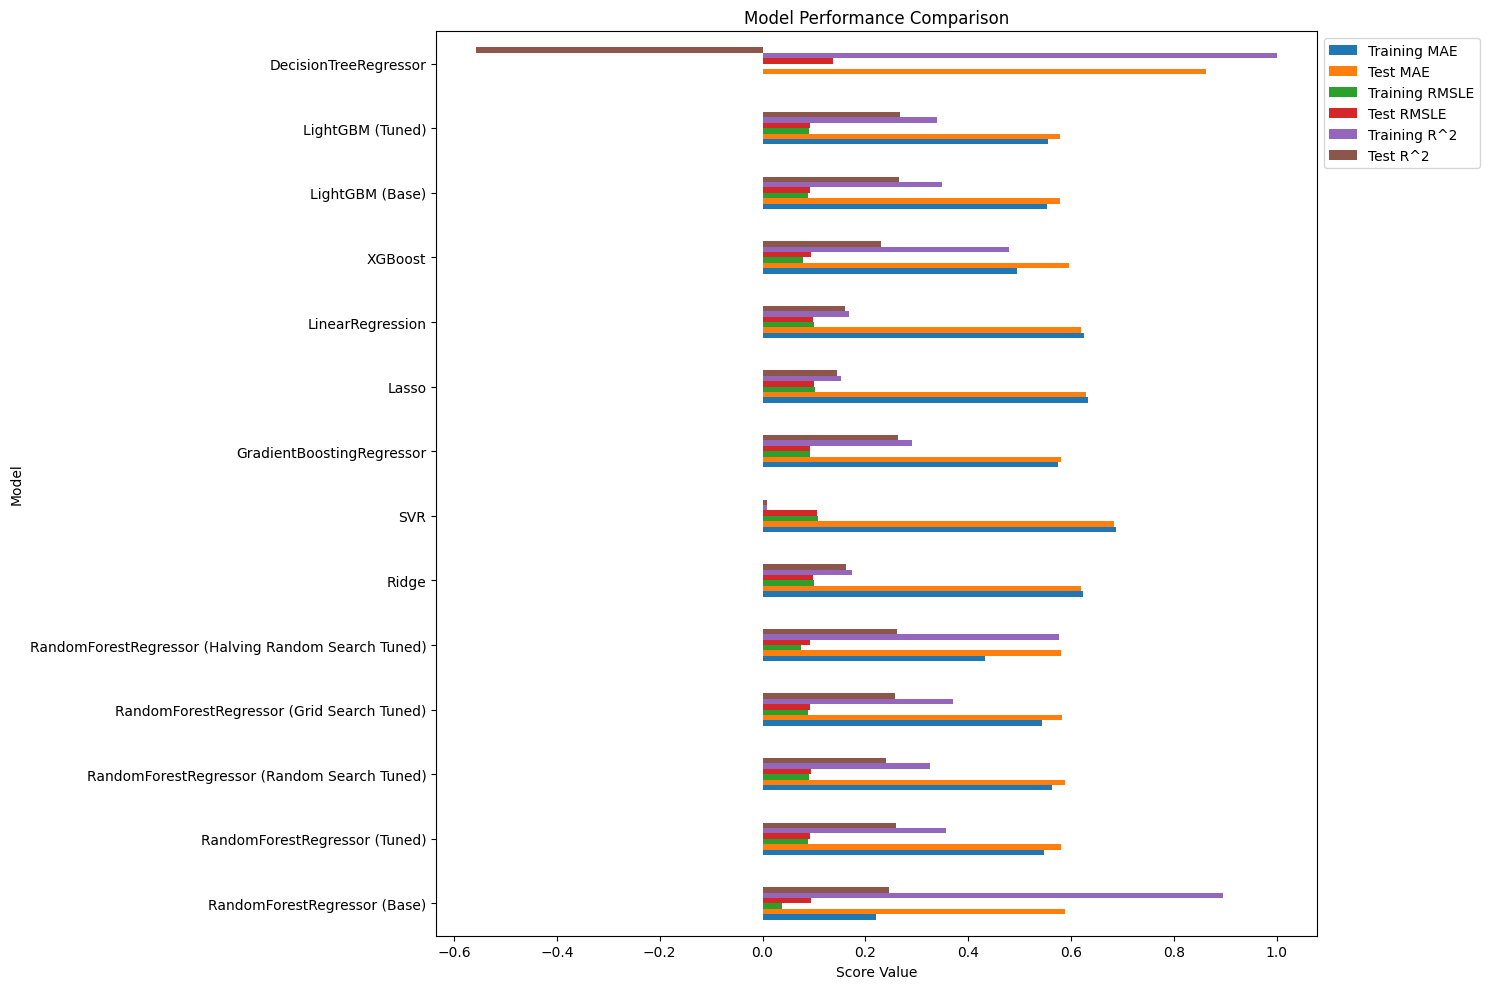

In [ ]:
model_scores = pd.DataFrame({
    "RandomForestRegressor (Base)": base_model_scores,
    "RandomForestRegressor (Tuned)": rs_model_scores,
    "RandomForestRegressor (Random Search Tuned)": rf_best_model_rs_scores,
    "RandomForestRegressor (Grid Search Tuned)": rf_best_model_gs_scores,
    "RandomForestRegressor (Halving Random Search Tuned)": halving_rs_model_scores,
    "Ridge": ridge_scores,
    "SVR": svr_scores,
    "GradientBoostingRegressor": gbr_scores,
    "Lasso": lasso_scores,
    "LinearRegression": linear_scores,
    "XGBoost": xgb_scores,
    "LightGBM (Base)": base_lgb_scores,
    "LightGBM (Tuned)": tuned_lgb_scores,
    "DecisionTreeRegressor": dt_scores
})

model_scores = model_scores.transpose()

fig, ax = plt.subplots(figsize=(15, 10))
model_scores.plot(kind="barh", ax=ax)
ax.set_title("Model Performance Comparison")
ax.set_xlabel("Score Value")
ax.set_ylabel("Model")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

This code block focuses on visualizing the performance of the machine learning models trained and evaluated previously. It specifically creates a horizontal bar chart to compare the Test R^2 score for each model.

<ipython-input-107-43a2ba204d6a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Test R^2", y="model_name", data=model_comparison_df_sorted, palette="viridis")


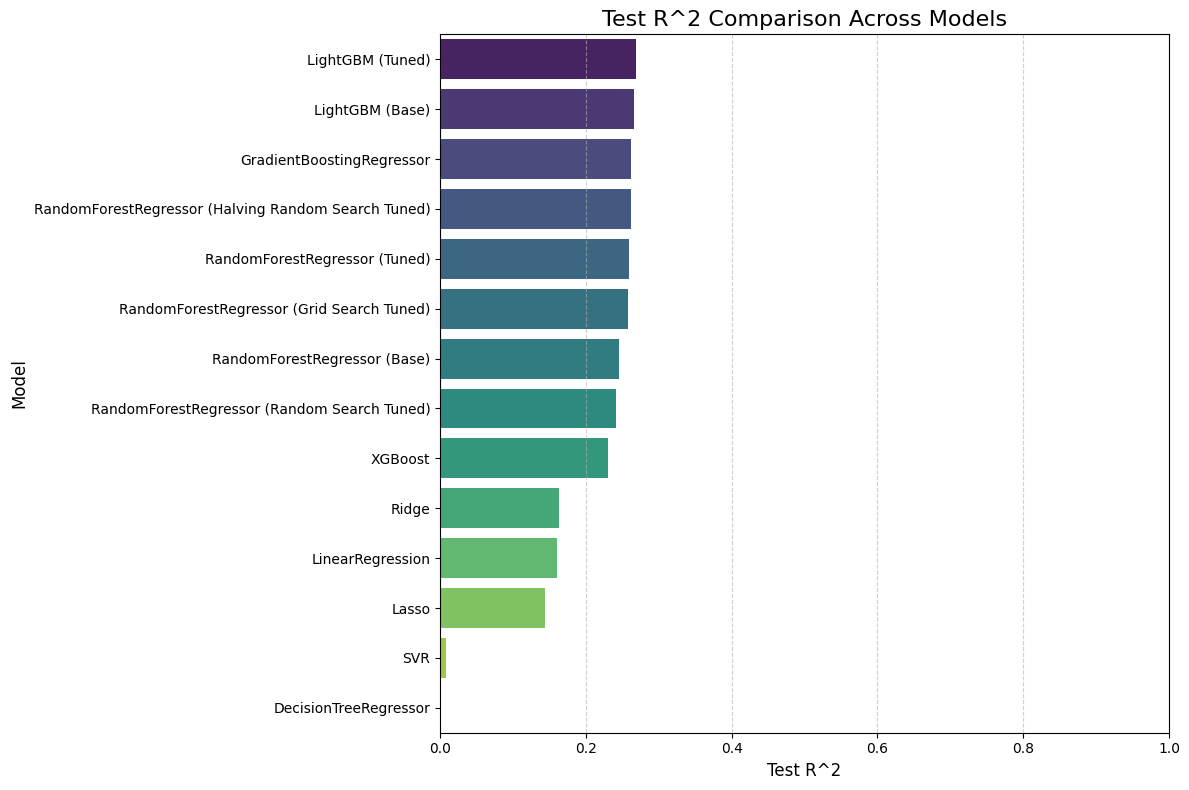

In [ ]:
model_comparison_df_sorted = model_comparison_df.sort_values(by="Test R^2", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Test R^2", y="model_name", data=model_comparison_df_sorted, palette="viridis")
plt.title("Test R^2 Comparison Across Models", fontsize=16)
plt.xlabel("Test R^2", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Machine Learning Model (Total Completed)

This code block prepares the sample data for training a machine learning model to predict the 'user_completed'.

In [ ]:
sample = user_country_stats.sample(n=1000, random_state=42)

x_sample = sample.drop(labels="user_completed", axis=1)
y_sample = np.log1p(sample["user_completed"])

This code block splits the data into training and testing sets.

In [ ]:
x_sample_train, x_sample_test, y_sample_train, y_sample_test = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42)

This code block splits the main dataset into features and the target variable, and then further divides these into training and testing sets.

In [ ]:
X = user_country_stats.drop('user_completed', axis=1)
y = np.log1p(user_country_stats['user_completed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This code block focuses on cleaning the column names of training and testing feature sets, X_train and X_test.

In [ ]:
X_train.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_train.columns]
X_test.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_test.columns]

This code block trains a baseline machine learning model, specifically a Random Forest Regressor, on a sample of the sample data and then evaluates its performance.

In [ ]:
np.random.seed(42)

base_model_sample = RandomForestRegressor(n_jobs=-1)

base_model_sample.fit(X=x_sample_train, y=y_sample_train)

base_model_sample_scores = show_scores(model=base_model_sample,
                                       train_features=x_sample_train,
                                       train_labels=y_sample_train,
                                       test_features=x_sample_test,
                                       test_labels=y_sample_test)

print(f"Model score on {len(sample)} samples:")
base_model_sample_scores

Model score on 1000 samples:


{'Training MAE': 0.130003875443669,
 'Test MAE': 0.3813792642886928,
 'Training RMSLE': 0.04109369523920908,
 'Test RMSLE': 0.1327517882889829,
 'Training R^2': 0.9818933262318,
 'Test R^2': 0.8587871454038378}

This code block tunes the hyperparameters of a Random Forest Regressor model using a technique called Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1),
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"], }

sample_rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=3,
                              verbose=3)

sample_rs_model.fit(X=x_sample_train,
                    y=y_sample_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.820 total time=   0.4s
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.805 total time=   0.4s
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.821 total time=   0.4s
[CV 1/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.880 total time=   0.3s
[CV 2/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.861 total time=   0.3s
[CV 3/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.859 total time=   0.3s
[CV 1/3] END max_depth=10, max_features=0.5, min_samples_leaf=9, min_samples_split=5, n_estimators=140;, score=0.882 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=3)

In [ ]:
sample_rs_model.best_params_

{'n_estimators': np.int64(100),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(6),
 'max_features': 0.5,
 'max_depth': None}

In [ ]:
sample_rs_model_scores = show_scores(model=sample_rs_model,
                                     train_features=x_sample_train,
                                     train_labels=y_sample_train,
                                     test_features=x_sample_test,
                                     test_labels=y_sample_test)
sample_rs_model_scores

{'Training MAE': 0.23123880501433647,
 'Test MAE': 0.37506713463342095,
 'Training RMSLE': 0.07391614223660027,
 'Test RMSLE': 0.13168306425054546,
 'Training R^2': 0.9402052980423313,
 'Test R^2': 0.8627250829412689}

This code block performs a Grid Search to find the best hyperparameters for a RandomForestRegressor model using the sample training data.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(50, 150, 50),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 8, 2),
           "min_samples_leaf": np.arange(2, 6, 2),
           "max_features": [0.5, "sqrt"],
           "oob_score": [True, False]
}

sample_gs_model = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                              param_grid=rf_grid,
                              cv=3,
                              verbose=3,
                              n_jobs=-1)

sample_gs_model.fit(X=x_sample_train,
                    y=y_sample_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [0.5, 'sqrt'],
                         'min_samples_leaf': array([2, 4]),
                         'min_samples_split': array([2, 4, 6]),
                         'n_estimators': array([ 50, 100]),
                         'oob_score': [True, False]},
             verbose=3)

In [ ]:
sample_gs_model.best_params_

{'max_depth': 10,
 'max_features': 0.5,
 'min_samples_leaf': np.int64(4),
 'min_samples_split': np.int64(6),
 'n_estimators': np.int64(100),
 'oob_score': False}

In [ ]:
sample_gs_model_scores = show_scores(model=sample_rs_model,
                                     train_features=x_sample_train,
                                     train_labels=y_sample_train,
                                     test_features=x_sample_test,
                                     test_labels=y_sample_test)
sample_gs_model_scores

{'Training MAE': 0.23123880501433647,
 'Test MAE': 0.37506713463342095,
 'Training RMSLE': 0.07391614223660027,
 'Test RMSLE': 0.13168306425054546,
 'Training R^2': 0.9402052980423313,
 'Test R^2': 0.8627250829412689}

This code block sets up and runs a HalvingRandomSearchCV for a RandomForestRegressor model. The goal is to find the best combination of hyperparameters for the model efficiently.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1),
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"],
           "oob_score": [True, False]}

sample_hrs_model = HalvingRandomSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                                        param_distributions=rf_grid,
                                        cv=3,
                                        verbose=3,
                                        n_jobs=-1)

sample_hrs_model.fit(X=x_sample_train,
                    y=y_sample_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 6
max_resources_: 800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 133
n_resources: 6
Fitting 3 folds for each of 133 candidates, totalling 399 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(


----------
iter: 1
n_candidates: 45
n_resources: 18
Fitting 3 folds for each of 45 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 2
n_candidates: 15
n_resources: 54
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 3
n_candidates: 5
n_resources: 162
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

----------
iter: 4
n_candidates: 2
n_resources: 486
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan        

HalvingRandomSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
                      n_jobs=-1,
                      param_distributions={'max_depth': [None, 10, 20],
                                           'max_features': [0.5, 1.0, 'sqrt'],
                                           'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                           'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                           'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190]),
                                           'oob_score': [True, False]},
                      verbose=3)

In [ ]:
sample_hrs_model.best_params_

{'oob_score': True,
 'n_estimators': np.int64(120),
 'min_samples_split': np.int64(7),
 'min_samples_leaf': np.int64(3),
 'max_features': 1.0,
 'max_depth': None}

In [ ]:
sample_hrs_model_scores = show_scores(model=sample_hrs_model,
                                     train_features=x_sample_train,
                                      train_labels=y_sample_train,
                                      test_features=x_sample_test,
                                      test_labels=y_sample_test)
sample_hrs_model_scores

{'Training MAE': 0.1714868669221164,
 'Test MAE': 0.37873365950620896,
 'Training RMSLE': 0.05815846916238737,
 'Test RMSLE': 0.13302086010875291,
 'Training R^2': 0.9643432868723696,
 'Test R^2': 0.8582603323812968}

This code block trains a baseline machine learning model, specifically a Random Forest Regressor, on the full training dataset and then evaluates its performance.

In [ ]:
base_model = RandomForestRegressor(n_jobs=-1)

base_model.fit(X=X_train, y=y_train)

base_model_scores = show_scores(model=base_model,
                                train_features=X_train,
                                train_labels=y_train,
                                test_features=X_test,
                                test_labels=y_test)
base_model_scores

{'Training MAE': 0.1147896729302036,
 'Test MAE': 0.30908671413580363,
 'Training RMSLE': 0.03708440936342342,
 'Test RMSLE': 0.09498849454251997,
 'Training R^2': 0.9857995697546297,
 'Test R^2': 0.8990780678226931}

This code block focuses on tuning the hyperparameters of a RandomForestRegressor model using Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1),
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"], }

rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=3,
                              verbose=3)

rs_model.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.879 total time=  11.0s
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.881 total time=  11.7s
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=130;, score=0.882 total time=  12.1s
[CV 1/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.898 total time=  31.0s
[CV 2/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.897 total time=  31.8s
[CV 3/3] END max_depth=None, max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60;, score=0.898 total time=  31.3s
[CV 1/3] END max_depth=10, max_features=0.5, min_samples_leaf=9, min_samples_split=5, n_estimators=140;, score=0.896 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=3)

In [ ]:
rs_model.best_params_

{'n_estimators': np.int64(100),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(6),
 'max_features': 0.5,
 'max_depth': None}

In [ ]:
rs_model_scores = show_scores(model=rs_model,
                              train_features=X_train,
                              train_labels=y_train,
                              test_features=X_test,
                              test_labels=y_test)
rs_model_scores

{'Training MAE': 0.20600592840252008,
 'Test MAE': 0.3070391800429582,
 'Training RMSLE': 0.06703012962055793,
 'Test RMSLE': 0.09451263235674658,
 'Training R^2': 0.9522656114002397,
 'Test R^2': 0.9004190995040829}

This code block takes the best hyperparameters found during a previous randomized search on a sample of the data (sample_rs_model.best_params_) and uses them to train a new RandomForestRegressor model on the full training dataset (X_train, y_train).

In [ ]:
np.random.seed(42)

rf_best_model_rs = RandomForestRegressor(**sample_rs_model.best_params_, n_jobs=-1)

rf_best_model_rs.fit(X=X_train,
                  y=y_train)

rf_best_model_rs_scores = show_scores(model=rf_best_model_rs,
                                   train_features=X_train,
                                   train_labels=y_train,
                                   test_features=X_test,
                                   test_labels=y_test)

rf_best_model_rs_scores

{'Training MAE': 0.20628827753240644,
 'Test MAE': 0.30714110904178904,
 'Training RMSLE': 0.06723179714995035,
 'Test RMSLE': 0.0946891465476195,
 'Training R^2': 0.9520839078508789,
 'Test R^2': 0.9001482904069469}

This code block trains a machine learning model, specifically a Random Forest Regressor, using the optimal hyperparameters found during a previous Grid Search performed on a sample of the data. It then evaluates the performance of this trained model.

In [ ]:
np.random.seed(42)

rf_best_model_gs = RandomForestRegressor(**sample_gs_model.best_params_, n_jobs=-1)

rf_best_model_gs.fit(X=X_train,
                  y=y_train)

rf_best_model_gs_scores = show_scores(model=rf_best_model_gs,
                                   train_features=X_train,
                                   train_labels=y_train,
                                   test_features=X_test,
                                   test_labels=y_test)

rf_best_model_gs_scores

{'Training MAE': 0.2813504894202222,
 'Test MAE': 0.3125488510529735,
 'Training RMSLE': 0.084329907243666,
 'Test RMSLE': 0.0962194210575584,
 'Training R^2': 0.9170215795969648,
 'Test R^2': 0.8966511339215021}

This code block trains a machine learning model, specifically a Random Forest Regressor, using the optimal hyperparameters found during a previous Halving Randomized Search performed on a sample of the data. It then evaluates the performance of this trained model.

In [ ]:
np.random.seed(42)

rf_best_model_hrs = RandomForestRegressor(**sample_hrs_model.best_params_, n_jobs=-1)

rf_best_model_hrs.fit(X=X_train,
                  y=y_train)

rf_best_model_hrs_scores = show_scores(model=rf_best_model_hrs,
                                   train_features=X_train,
                                   train_labels=y_train,
                                   test_features=X_test,
                                   test_labels=y_test)

rf_best_model_hrs_scores

{'Training MAE': 0.15360517978759128,
 'Test MAE': 0.3075155880619641,
 'Training RMSLE': 0.05238095852765688,
 'Test RMSLE': 0.09486459280397695,
 'Training R^2': 0.9720017938797965,
 'Test R^2': 0.899669019082767}

This code block is setting up and running a HalvingRandomSearchCV for a RandomForestRegressor model. The goal is to efficiently find the best combination of hyperparameters for the model by exploring a range of possible values.

In [ ]:
np.random.seed(42)

rf_grid = {"n_estimators": np.arange(50, 300, 25),
           "max_depth": [10, 20, 30, None],
           "min_samples_split": np.arange(5, 20, 2),
           "min_samples_leaf": np.arange(3, 15, 2),
           "max_features": [0.5, 0.7, 1.0, "sqrt"],
           "bootstrap": [True, False],
           "oob_score": [True, False]}

halving_rs_model = HalvingRandomSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                                        param_distributions=rf_grid,
                                        cv=5,
                                        verbose=3,
                                        n_jobs=-1)

halving_rs_model.fit(X_train, y_train)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 10
max_resources_: 48739
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4873
n_resources: 10
Fitting 5 folds for each of 4873 candidates, totalling 24365 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6055 fits failed out of a total of 24365.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6055 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 448, in fit
    raise ValueError("Out 

----------
iter: 1
n_candidates: 1625
n_resources: 30
Fitting 5 folds for each of 1625 candidates, totalling 8125 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2005 fits failed out of a total of 8125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2005 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 448, in fit
    raise ValueError("Out o

----------
iter: 2
n_candidates: 542
n_resources: 90
Fitting 5 folds for each of 542 candidates, totalling 2710 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.78329337 0.77091195 0.78887377]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [           nan            nan 2.22044605e-17 ... 9.43989510e-01
 9.44236228e-01 9.41721233e-01]
  warnings.warn(


----------
iter: 3
n_candidates: 181
n_resources: 270
Fitting 5 folds for each of 181 candidates, totalling 905 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.88139832 0.88040493 0.8817603 ]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [           nan            nan 2.22044605e-17 ... 9.33156560e-01
 9.56622974e-01 9.28866445e-01]
  warnings.warn(


----------
iter: 4
n_candidates: 61
n_resources: 810
Fitting 5 folds for each of 61 candidates, totalling 305 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.86292838 0.86057441 0.86154951]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [           nan            nan 2.22044605e-17 ... 9.47459311e-01
 9.57169947e-01 9.63778872e-01]
  warnings.warn(


----------
iter: 5
n_candidates: 21
n_resources: 2430
Fitting 5 folds for each of 21 candidates, totalling 105 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.88841919 0.88930831 0.88824689]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [           nan            nan 2.22044605e-17 ... 9.66115860e-01
 9.66195706e-01 9.56312011e-01]
  warnings.warn(


----------
iter: 6
n_candidates: 7
n_resources: 7290
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.89208927 0.8906289  0.89175418]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [           nan            nan 2.22044605e-17 ... 9.67612936e-01
 9.55223592e-01 9.69503262e-01]
  warnings.warn(


----------
iter: 7
n_candidates: 3
n_resources: 21870
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.89383726 0.8941225  0.89389012]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [           nan            nan 2.22044605e-17 ... 9.70743059e-01
 9.65005180e-01 9.68384938e-01]
  warnings.warn(


HalvingRandomSearchCV(estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
                      param_distributions={'bootstrap': [True, False],
                                           'max_depth': [10, 20, 30, None],
                                           'max_features': [0.5, 0.7, 1.0,
                                                            'sqrt'],
                                           'min_samples_leaf': array([ 3,  5,  7,  9, 11, 13]),
                                           'min_samples_split': array([ 5,  7,  9, 11, 13, 15, 17, 19]),
                                           'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275]),
                                           'oob_score': [True, False]},
                      verbose=3)

In [ ]:
halving_rs_model.best_params_

{'oob_score': False,
 'n_estimators': np.int64(275),
 'min_samples_split': np.int64(9),
 'min_samples_leaf': np.int64(3),
 'max_features': 0.5,
 'max_depth': 30,
 'bootstrap': True}

In [ ]:
halving_rs_model_scores = show_scores(model=halving_rs_model,
                              train_features=X_train,
                              train_labels=y_train,
                              test_features=X_test,
                              test_labels=y_test)
halving_rs_model_scores

{'Training MAE': 0.17213128569220962,
 'Test MAE': 0.3060477646387894,
 'Training RMSLE': 0.05773162601307981,
 'Test RMSLE': 0.09424251744864517,
 'Training R^2': 0.9656421524008112,
 'Test R^2': 0.9010002768665863}

This code block trains a Ridge Regression model. It then evaluates the trained model's performance using show_scores function and prints the resulting scores.

In [ ]:
ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_scores = show_scores(model=ridge_model,
                           train_features=X_train,
                           train_labels=y_train,
                           test_features=X_test,
                           test_labels=y_test)

print("Ridge Regression Scores:")
ridge_scores

Ridge Regression Scores:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.93358e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


{'Training MAE': 0.5053638001571152,
 'Test MAE': 0.5116727139965214,
 'Training RMSLE': 0.16089547197896378,
 'Test RMSLE': 0.16337398324994443,
 'Training R^2': 0.715090531088409,
 'Test R^2': 0.713378505293234}

This code block trains and evaluates a Support Vector Regression (SVR) model with a Radial Basis Function (RBF) kernel.

In [ ]:
svr_model = SVR(kernel="rbf")

svr_model.fit(X_train, y_train)

svr_scores = show_scores(model=svr_model,
                         train_features=X_train,
                         train_labels=y_train,
                         test_features=X_test,
                         test_labels=y_test)

print("SVR (RBF Kernel) Scores:")
svr_scores

SVR (RBF Kernel) Scores:


{'Training MAE': 0.9779449940783711,
 'Test MAE': 0.99666998420428,
 'Training RMSLE': 0.2744357301503668,
 'Test RMSLE': 0.27800511623576585,
 'Training R^2': -0.001117245209311335,
 'Test R^2': -0.003981500634482105}

This code block trains and evaluates a Gradient Boosting Regressor.

In [ ]:
gbr_model = GradientBoostingRegressor(random_state=42)

gbr_model.fit(X_train, y_train)

gbr_scores = show_scores(model=gbr_model,
                         train_features=X_train,
                         train_labels=y_train,
                         test_features=X_test,
                         test_labels=y_test)

print("Gradient Boosting Regressor Scores:")
gbr_scores

Gradient Boosting Regressor Scores:


{'Training MAE': 0.30389162740478387,
 'Test MAE': 0.30984062347150193,
 'Training RMSLE': 0.09282702678541804,
 'Test RMSLE': 0.09590938220808858,
 'Training R^2': 0.9018795942785915,
 'Test R^2': 0.8984747976960277}

This code block focuses on training and evaluating a Lasso Regression model.

In [ ]:
lasso_model = Lasso(random_state=42)

lasso_model.fit(X_train, y_train)

lasso_scores = show_scores(model=lasso_model,
                           train_features=X_train,
                           train_labels=y_train,
                           test_features=X_test,
                           test_labels=y_test)

print("Lasso Regression Scores:")
lasso_scores

Lasso Regression Scores:


{'Training MAE': 0.5209360283357984,
 'Test MAE': 0.5283622787436629,
 'Training RMSLE': 0.16764985050268763,
 'Test RMSLE': 0.17008630946811817,
 'Training R^2': 0.6900910758890415,
 'Test R^2': 0.6863303337304982}

This code block focuses on training and evaluating a Linear Regression model.

In [ ]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_scores = show_scores(model=linear_model,
                            train_features=X_train,
                            train_labels=y_train,
                            test_features=X_test,
                            test_labels=y_test)

print("Linear Regression Scores:")
linear_scores

Linear Regression Scores:


{'Training MAE': 0.5059397048393599,
 'Test MAE': 0.5116965593521995,
 'Training RMSLE': 0.16118324740043635,
 'Test RMSLE': 0.16342822192065326,
 'Training R^2': 0.7138698122672583,
 'Test R^2': 0.7127963300318897}

This code block trains and evaluates a XGBoost (Extreme Gradient Boosting) Regressor model.

In [ ]:
base_xgb_model  = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

base_xgb_model .fit(X_train, y_train)

base_xgb_scores  = show_scores(model=base_xgb_model ,
                         train_features=X_train,
                         train_labels=y_train,
                         test_features=X_test,
                         test_labels=y_test)

print("XGBoost Regressor Scores:")
base_xgb_scores

XGBoost Regressor Scores:


{'Training MAE': 0.2536544976611989,
 'Test MAE': 0.30436832038810135,
 'Training RMSLE': 0.0752648563822963,
 'Test RMSLE': 0.09283392402772897,
 'Training R^2': 0.9317988288515144,
 'Test R^2': 0.9031307536741923}

This code block trains and evaluates a LightGBM Regressor model.

In [ ]:
base_lgb_model  = lgb.LGBMRegressor(objective='regression', random_state=42)

base_lgb_model .fit(X_train, y_train)

base_lgb_scores = show_scores(model=base_lgb_model ,
                          train_features=X_train,
                          train_labels=y_train,
                          test_features=X_test,
                          test_labels=y_test)

print("LightGBM Regressor Scores:")
base_lgb_scores

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 48739, number of used features: 64
[LightGBM] [Info] Start training from score 4.661177
LightGBM Regressor Scores:


{'Training MAE': 0.2870195235970119,
 'Test MAE': 0.3023409923759415,
 'Training RMSLE': 0.086228159451186,
 'Test RMSLE': 0.09277016927780582,
 'Training R^2': 0.913294810653629,
 'Test R^2': 0.9034944103523949}

This code block trains and evaluates a Decision Tree Regressor model.

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)

dt_model.fit(X_train, y_train)

dt_scores = show_scores(model=dt_model,
                        train_features=X_train,
                        train_labels=y_train,
                        test_features=X_test,
                        test_labels=y_test)

print("Decision Tree Regression Scores:")
dt_scores

Decision Tree Regression Scores:


{'Training MAE': 2.733473459755407e-19,
 'Test MAE': 0.4369118147038949,
 'Training RMSLE': 4.609051551627045e-18,
 'Test RMSLE': 0.13364573426272688,
 'Training R^2': 1.0,
 'Test R^2': 0.7966488688870226}

Because LightGBM Regressor and XGBoost regressor produced the best score, we will try to tune them to get an even better score.

This code block focuses on tuning the hyperparameters of a LightGBM Regressor model using Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

lgb_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

tuned_lgb_model = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42),
                                       param_distributions=lgb_grid,
                                       n_iter=20,
                                       cv=3,
                                       verbose=3,
                                       n_jobs=-1)

tuned_lgb_model.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7622
[LightGBM] [Info] Number of data points in the train set: 48739, number of used features: 64
[LightGBM] [Info] Start training from score 4.661177


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [-1, 10, 20],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.8, 1.0]},
                   verbose=3)

In [ ]:
tuned_lgb_model.best_params_

{'subsample': 0.8,
 'num_leaves': 50,
 'n_estimators': 200,
 'min_child_samples': 100,
 'max_depth': 20,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

In [ ]:
tuned_lgb_scores = show_scores(model=tuned_lgb_model,
                               train_features=X_train,
                               train_labels=y_train,
                               test_features=X_test,
                               test_labels=y_test)
tuned_lgb_scores

{'Training MAE': 0.2632752187154248,
 'Test MAE': 0.3004680227127976,
 'Training RMSLE': 0.07818204511923915,
 'Test RMSLE': 0.0914804596951764,
 'Training R^2': 0.9273158272823236,
 'Test R^2': 0.9053268766949052}

This code block focuses on tuning the hyperparameters of an XGBoost Regressor model using Randomized Search Cross-Validation.

In [ ]:
np.random.seed(42)

xgb_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

tuned_xgb_model = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=42),
                                       param_distributions=xgb_grid,
                                       n_iter=20,
                                       cv=3,
                                       verbose=3,
                                       n_jobs=-1)

tuned_xgb_model.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5],
                                        'subsample': [0.8, 1.0]},
                   verbose=3)

In [ ]:
tuned_xgb_model.best_params_

{'subsample': 1.0,
 'reg_lambda': 0.5,
 'reg_alpha': 0.1,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [ ]:
tuned_xgb_scores = show_scores(model=tuned_xgb_model,
                               train_features=X_train,
                               train_labels=y_train,
                               test_features=X_test,
                               test_labels=y_test)
tuned_xgb_scores

{'Training MAE': 0.27987266362220287,
 'Test MAE': 0.3017201220262196,
 'Training RMSLE': 0.08396133552799324,
 'Test RMSLE': 0.09261907676734066,
 'Training R^2': 0.9173263065995793,
 'Test R^2': 0.904209000164871}

This code block is used to organize and compare the performance scores of various machine learning models that were trained and evaluated in the preceding cells.

In [ ]:
base_model_scores["model_name"] = "RandomForestRegressor (Base)"
rs_model_scores["model_name"] = "RandomForestRegressor (Tuned)"
ridge_scores["model_name"] = "Ridge"
svr_scores["model_name"] = "SVR"
gbr_scores["model_name"] = "GradientBoostingRegressor"
lasso_scores["model_name"] = "Lasso"
linear_scores["model_name"] = "LinearRegression"
base_xgb_scores["model_name"] = "XGBoost (Base)"
base_lgb_scores["model_name"] = "LightGBM (Base)"
tuned_xgb_scores["model_name"] = "XGBoost (Tuned)"
tuned_lgb_scores["model_name"] = "LightGBM (Tuned)"
dt_scores["model_name"] = "DecisionTreeRegressor"
rf_best_model_rs_scores["model_name"] = "RandomForestRegressor (Random Search Tuned)"
rf_best_model_gs_scores["model_name"] = "RandomForestRegressor (Grid Search Tuned)"
halving_rs_model_scores["model_name"] = "RandomForestRegressor (Halving Random Search Tuned)"


all_model_scores = [base_model_scores,
                    rs_model_scores,
                    rf_best_model_rs_scores,
                    rf_best_model_gs_scores,
                    halving_rs_model_scores,
                    ridge_scores,
                    svr_scores,
                    gbr_scores,
                    lasso_scores,
                    linear_scores,
                    base_xgb_scores,
                    base_lgb_scores,
                    tuned_xgb_scores,
                    tuned_lgb_scores,
                    dt_scores]

model_comparison_df = pd.DataFrame(all_model_scores).sort_values(by="Test R^2", ascending=True)
model_comparison_df

Training MAE  Test MAE  Training RMSLE  Test RMSLE  Training R^2  \
6   9.779450e-01  0.996670    2.744357e-01    0.278005     -0.001117   
8   5.209360e-01  0.528362    1.676499e-01    0.170086      0.690091   
9   5.059397e-01  0.511697    1.611832e-01    0.163428      0.713870   
5   5.053638e-01  0.511673    1.608955e-01    0.163374      0.715091   
14  2.733473e-19  0.436912    4.609052e-18    0.133646      1.000000   
3   2.813505e-01  0.312549    8.432991e-02    0.096219      0.917022   
7   3.038916e-01  0.309841    9.282703e-02    0.095909      0.901880   
0   1.147897e-01  0.309087    3.708441e-02    0.094988      0.985800   
2   2.062883e-01  0.307141    6.723180e-02    0.094689      0.952084   
1   2.060059e-01  0.307039    6.703013e-02    0.094513      0.952266   
4   1.721313e-01  0.306048    5.773163e-02    0.094243      0.965642   
10  2.536545e-01  0.304368    7.526486e-02    0.092834      0.931799   
11  2.870195e-01  0.302341    8.622816e-02    0.092770      0.913295   
12  2.798727e-01  0.301720    8.396134e-02    0.092619      0.917326   
13  2.632752e-01  0.300468    7.818205e-02    0.091480      0.927316   

    Test R^2                                         model_name  
6  -0.003982                                                SVR  
8   0.686330                                              Lasso  
9   0.712796                                   LinearRegression  
5   0.713379                                              Ridge  
14  0.796649                              DecisionTreeRegressor  
3   0.896651          RandomForestRegressor (Grid Search Tuned)  
7   0.898475                          GradientBoostingRegressor  
0   0.899078                       RandomForestRegressor (Base)  
2   0.900148        RandomForestRegressor (Random Search Tuned)  
1   0.900419                      RandomForestRegressor (Tuned)  
4   0.901000  RandomForestRegressor (Halving Random Search T...  
10  0.903131                                     XGBoost (Base)  
11  0.903494                                    LightGBM (Base)  
12  0.904209                                    XGBoost (Tuned)  
13  0.905327                                   LightGBM (Tuned)

This code block focuses on visualizing the performance of the various machine learning models trained in the previous steps. It creates a bar chart to easily compare the scores of each model.

In [ ]:
model_scores = pd.DataFrame({
    "RandomForestRegressor (Base)": base_model_scores,
    "RandomForestRegressor (Tuned)": rs_model_scores,
    "RandomForestRegressor (Random Search Tuned)": rf_best_model_rs_scores,
    "RandomForestRegressor (Grid Search Tuned)": rf_best_model_gs_scores,
    "RandomForestRegressor (Halving Random Search Tuned)": halving_rs_model_scores,
    "Ridge": ridge_scores,
    "SVR": svr_scores,
    "GradientBoostingRegressor": gbr_scores,
    "Lasso": lasso_scores,
    "LinearRegression": linear_scores,
    "LightGBM (Base)": base_lgb_scores,
    "LightGBM (Tuned)": tuned_lgb_scores,
    "XGBoost (Base)": base_xgb_scores,
    "XGBoost (Tuned)": tuned_xgb_scores,
    "DecisionTreeRegressor": dt_scores
})

model_scores = model_scores.transpose()

fig, ax = plt.subplots(figsize=(15, 10))
model_scores.plot(kind="barh", ax=ax)
ax.set_title("Model Performance Comparison")
ax.set_xlabel("Score Value")
ax.set_ylabel("Model")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

This code block focuses on visualizing the performance of the machine learning models trained and evaluated previously. It specifically creates a horizontal bar chart to compare the Test R^2 score for each model.

<ipython-input-87-43a2ba204d6a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Test R^2", y="model_name", data=model_comparison_df_sorted, palette="viridis")


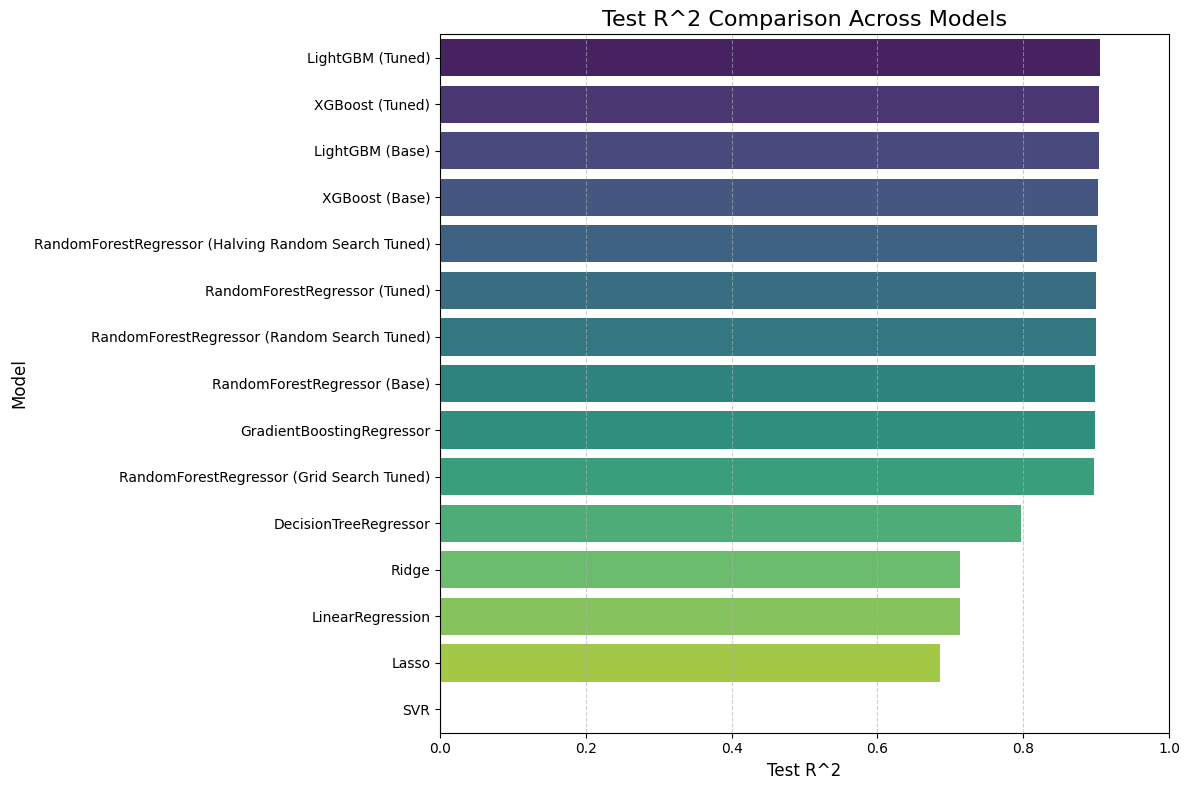

In [ ]:
model_comparison_df_sorted = model_comparison_df.sort_values(by="Test R^2", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Test R^2", y="model_name", data=model_comparison_df_sorted, palette="viridis")
plt.title("Test R^2 Comparison Across Models", fontsize=16)
plt.xlabel("Test R^2", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Conclusion

In this project, we successfully integrated multiple rich datasets — including the World Happiness Report, World Bank indicators, and MyAnimeList user data — to construct a unified, clean, and feature-rich dataset suitable for machine learning applications. The comprehensive data preprocessing phase involved merging diverse datasets on country-level attributes, handling extensive missing values, encoding categorical variables, and engineering new features from user behavior data.

The machine learning workflow involved setting up models to predict and analyze key user engagement metrics such as stats_mean_score (average anime rating given by a user) and user_completed (number of completed anime). A variety of regression models were employed, including:

*   Random Forest Regressor

*   Ridge Regression

*   Gradient Boosting Regressor

*   Support Vector Regression (SVR)

*   XGBoost

*   LightGBM

*   Linear Regression

*   Decision Tree Regressor

Hyperparameter tuning techniques, such as GridSearchCV, RandomizedSearchCV, and HalvingRandomSearchCV, were implemented to optimize model performance efficiently. Additionally, key performance metrics like Mean Absolute Error (MAE) and Root Mean Squared Log Error (RMSLE) were used to evaluate and compare models

After comparing model performances based on evaluation metrics such as R^2, Mean Absolute Error (MAE) and Root Mean Squared Log Error (RMSLE), it was found that the tuned LightGBM model consistently outperformed other models for both key targets. It's score was 0.268188 for stats_mean_sccore and 0.905327 for user_completed.

For future work, deploying these models and further refining feature importance analysis could uncover deeper insights into what drives digital engagement across different global contexts.